In [4]:
from __future__ import print_function
import tensorflow as tf
import cv2
import sys
import time 
sys.path.append("game/")
import wrapped_flappy_bird as game
import random
import numpy as np
from collections import deque
from matplotlib import pyplot as plt

In [5]:
GAME = 'bird' # the name of the game being played for log files
ACTIONS = 2 # number of valid actions
GAMMA = 0.99 # decay rate of past observations

OBSERVE = 10000
EXPLORE = 3000000
FINAL_EPSILON = 0.0001
INITIAL_EPSILON = 0.1

REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides = [1, stride, stride, 1], padding = "SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

def createNetwork():
    # network weights
    W_conv1 = weight_variable([8, 8, 4, 32])
    b_conv1 = bias_variable([32])

    W_conv2 = weight_variable([4, 4, 32, 64])
    b_conv2 = bias_variable([64])

    W_conv3 = weight_variable([3, 3, 64, 64])
    b_conv3 = bias_variable([64])

    W_fc1 = weight_variable([1600, 512])
    b_fc1 = bias_variable([512])

    W_fc2 = weight_variable([512, ACTIONS])
    b_fc2 = bias_variable([ACTIONS])

    # input layer
    s = tf.placeholder("float", [None, 80, 80, 4])

    # hidden layers
    h_conv1 = tf.nn.relu(conv2d(s, W_conv1, 4) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 2) + b_conv2)
    #h_pool2 = max_pool_2x2(h_conv2)

    h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 1) + b_conv3)
    #h_pool3 = max_pool_2x2(h_conv3)

    #h_pool3_flat = tf.reshape(h_pool3, [-1, 256])
    h_conv3_flat = tf.reshape(h_conv3, [-1, 1600])

    h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

    # readout layer
    readout = tf.matmul(h_fc1, W_fc2) + b_fc2

    return s, readout, h_fc1

In [7]:
def trainNetwork(s, readout, h_fc1, sess):
    tick = time.time()
    # define the cost function
    a = tf.placeholder("float", [None, ACTIONS])
    y = tf.placeholder("float", [None])
    readout_action = tf.reduce_sum(tf.multiply(readout, a), reduction_indices=1)
    cost = tf.reduce_mean(tf.square(y - readout_action))
    train_step = tf.train.AdamOptimizer(1e-6).minimize(cost)

    # open up a game state to communicate with emulator
    game_state = game.GameState()

    # store the previous observations in replay memory
    D = deque()

    # printing
    # a_file = open("logs_" + GAME + "/readout.txt", 'w')
    # h_file = open("logs_" + GAME + "/hidden.txt", 'w')

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)
    x_t = cv2.cvtColor(cv2.resize(x_t[:,:-110,:], (80, 80)), cv2.COLOR_BGR2GRAY)
    ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)
    x_t = x_t
    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    sess.run(tf.global_variables_initializer())
    '''
    # saving and loading networks
    saver = tf.train.Saver()
    checkpoint = tf.train.get_checkpoint_state("saved_networks")
    if checkpoint and checkpoint.model_checkpoint_path:
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print("Successfully loaded:", checkpoint.model_checkpoint_path)
    else:
        print("Could not find old network weights")'''

    # start training
    epsilon = INITIAL_EPSILON
    t = 0
    score = 0
    pscore = 0
    episode = 0
    while True:
        # choose an action epsilon greedily
        readout_t = readout.eval(feed_dict={s : [s_t]})[0]
        a_t = np.zeros([ACTIONS])
        action_index = 0
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                #print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[random.randrange(ACTIONS)] = 1
            else:
                action_index = np.argmax(readout_t)
                a_t[action_index] = 1
        else:
            a_t[0] = 1 # do nothing

        # scale down epsilon
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        # run the selected action and observe next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
        x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored[:,:-110,:], (80, 80)), cv2.COLOR_BGR2GRAY)
        ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
        x_t1 = np.reshape(x_t1, (80, 80, 1))
        #s_t1 = np.append(x_t1, s_t[:,:,1:], axis = 2)
        s_t1 = np.append(x_t1, s_t[:, :, :3], axis=2)

        # store the transition in D
        D.append((s_t, a_t, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        # only train if done observing
        if t > OBSERVE:
            # sample a minibatch to train on
            minibatch = random.sample(D, BATCH)

            # get the batch variables
            s_j_batch = [d[0] for d in minibatch]
            a_batch = [d[1] for d in minibatch]
            r_batch = [d[2] for d in minibatch]
            s_j1_batch = [d[3] for d in minibatch]

            y_batch = []
            readout_j1_batch = readout.eval(feed_dict = {s : s_j1_batch})
            for i in range(0, len(minibatch)):
                terminal = minibatch[i][4]
                # if terminal, only equals reward
                if terminal:
                    y_batch.append(r_batch[i])
                else:
                    y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

            # perform gradient step
            train_step.run(feed_dict = {
                y : y_batch,
                a : a_batch,
                s : s_j_batch}
            )

        # update the old values
        s_t = s_t1
        t += 1

        # save progress every 10000 iterations
        # if t % 10000 == 0:
        #   saver.save(sess, 'saved_networks/' + GAME + '-dqn', global_step = t)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"
            
        if(terminal):
            print("ts", t,"epsod",episode, "/state", state, \
                "/e", epsilon, "/SCORE", round(score, 3),"/pscore",pscore,"/rt", r_t, \
                "/ Q_MAX %e" % np.max(readout_t))
            score = 0
            pscore = 0
            episode += 1
        else:
            score += r_t
            if(r_t==1):
                pscore += 1
        if(pscore > 10):
            print("ts", t,"epsod",episode, "/state", state, \
                "/e", epsilon, "/SCORE", round(score, 3),"/pscore",pscore,"/rt", r_t, \
                "/ Q_MAX %e" % np.max(readout_t))
            print("Game_Ends_in Time:",int(time.time() - tick))
            break;
        # write info to files
        '''
        if t % 10000 <= 100:
            a_file.write(",".join([str(x) for x in readout_t]) + '\n')
            h_file.write(",".join([str(x) for x in h_fc1.eval(feed_dict={s:[s_t]})[0]]) + '\n')
            cv2.imwrite("logs_tetris/frame" + str(t) + ".png", x_t1)
        '''

In [8]:
def playGame():
    sess = tf.InteractiveSession()
    s, readout, h_fc1 = createNetwork()
    trainNetwork(s, readout, h_fc1, sess)

def main():
    playGame()

if __name__ == "__main__":
    main()

ts 49 epsod 0 /state observe /e 0.1 /SCORE 4.8 /pscore 0 /rt -1 / Q_MAX 1.187044e-02
ts 99 epsod 1 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.673500e-02
ts 149 epsod 2 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.179895e-02
ts 199 epsod 3 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.774333e-02
ts 249 epsod 4 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.843823e-02
ts 299 epsod 5 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.880450e-02
ts 349 epsod 6 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.058797e-02
ts 399 epsod 7 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.866412e-02
ts 449 epsod 8 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.699426e-02
ts 499 epsod 9 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.567178e-02
ts 549 epsod 10 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.993407e-02
ts 599 epsod 11 /state observe /e 0.1 /SCORE 4.9 /pscor

ts 4749 epsod 94 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.656931e-02
ts 4799 epsod 95 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.391308e-02
ts 4849 epsod 96 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.056173e-02
ts 4899 epsod 97 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.656931e-02
ts 4949 epsod 98 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.460341e-02
ts 4999 epsod 99 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.791722e-02
ts 5049 epsod 100 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.058797e-02
ts 5099 epsod 101 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.656931e-02
ts 5149 epsod 102 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.469221e-02
ts 5199 epsod 103 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.252077e-02
ts 5249 epsod 104 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.179895e-02
ts 5299 epsod 105 /state ob

ts 9399 epsod 187 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.843823e-02
ts 9449 epsod 188 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.494557e-02
ts 9499 epsod 189 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.218291e-02
ts 9549 epsod 190 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.357472e-02
ts 9599 epsod 191 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.146577e-02
ts 9649 epsod 192 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.982818e-02
ts 9699 epsod 193 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.754037e-02
ts 9749 epsod 194 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.187044e-02
ts 9799 epsod 195 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.781908e-02
ts 9849 epsod 196 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.349011e-02
ts 9899 epsod 197 /state observe /e 0.1 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 2.260800e-02
ts 9949 epsod 198 /st

ts 12503 epsod 266 /state explore /e 0.09991668340001608 /SCORE 3.2 /pscore 0 /rt 0.1 / Q_MAX 6.610238e+00
ts 12507 epsod 267 /state explore /e 0.09991655020001611 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 1.425041e+01
ts 12638 epsod 268 /state explore /e 0.09991218790001695 /SCORE 10.8 /pscore 0 /rt 0.1 / Q_MAX 7.047863e+00
ts 12755 epsod 269 /state explore /e 0.0999082918000177 /SCORE 8.3 /pscore 0 /rt 0.1 / Q_MAX 1.251094e+01
ts 12761 epsod 270 /state explore /e 0.09990809200001774 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 1.273991e+01
ts 12786 epsod 271 /state explore /e 0.0999072595000179 /SCORE 2.4 /pscore 0 /rt 0.1 / Q_MAX 8.135457e+00
ts 12872 epsod 272 /state explore /e 0.09990439570001845 /SCORE 6.3 /pscore 0 /rt 0.1 / Q_MAX 9.526885e+00
ts 12890 epsod 273 /state explore /e 0.09990379630001857 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 7.572455e+00
ts 13031 epsod 274 /state explore /e 0.09989910100001947 /SCORE 10.7 /pscore 0 /rt 0.1 / Q_MAX 9.279284e+00
ts 13057 epsod 275 /state explore /e 

ts 16810 epsod 343 /state explore /e 0.09977326030004376 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 7.026114e+00
ts 16882 epsod 344 /state explore /e 0.09977086270004422 /SCORE 6.0 /pscore 0 /rt 0.1 / Q_MAX 2.845901e+00
ts 16908 epsod 345 /state explore /e 0.09976999690004439 /SCORE 1.4 /pscore 0 /rt 0.1 / Q_MAX 8.890844e+00
ts 16909 epsod 346 /state explore /e 0.09976996360004439 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 7.693379e+00
ts 16938 epsod 347 /state explore /e 0.09976899790004458 /SCORE 2.8 /pscore 0 /rt 0.1 / Q_MAX 1.925806e+00
ts 16955 epsod 348 /state explore /e 0.09976843180004469 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 9.675839e+00
ts 16958 epsod 349 /state explore /e 0.09976833190004471 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 8.592987e+00
ts 16985 epsod 350 /state explore /e 0.09976743280004488 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 2.426627e+00
ts 17008 epsod 351 /state explore /e 0.09976666690004503 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 8.319793e+00
ts 17085 epsod 352 /state explore /e 0.

ts 19944 epsod 420 /state explore /e 0.0996688981000639 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX -2.665866e-01
ts 19947 epsod 421 /state explore /e 0.09966879820006391 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX -3.614310e-01
ts 20044 epsod 422 /state explore /e 0.09966556810006454 /SCORE 7.4 /pscore 0 /rt 0.1 / Q_MAX -3.281724e-01
ts 20085 epsod 423 /state explore /e 0.0996642028000648 /SCORE 2.9 /pscore 0 /rt 0.1 / Q_MAX 1.270777e+00
ts 20134 epsod 424 /state explore /e 0.09966257110006511 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 1.790101e+00
ts 20181 epsod 425 /state explore /e 0.09966100600006542 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 1.323852e+00
ts 20261 epsod 426 /state explore /e 0.09965834200006593 /SCORE 5.7 /pscore 0 /rt 0.1 / Q_MAX 3.269958e+00
ts 20301 epsod 427 /state explore /e 0.09965701000006619 /SCORE 2.8 /pscore 0 /rt 0.1 / Q_MAX 5.161349e+00
ts 20352 epsod 428 /state explore /e 0.09965531170006652 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 4.856884e+00
ts 20374 epsod 429 /state explore /e

ts 23618 epsod 497 /state explore /e 0.0995465539000875 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 2.394308e+00
ts 23622 epsod 498 /state explore /e 0.09954642070008753 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 2.084882e+00
ts 23623 epsod 499 /state explore /e 0.09954638740008753 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 2.016999e+00
ts 23625 epsod 500 /state explore /e 0.09954632080008755 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 1.787150e+00
ts 23629 epsod 501 /state explore /e 0.09954618760008757 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 1.418936e+00
ts 23632 epsod 502 /state explore /e 0.09954608770008759 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 1.073725e+00
ts 23701 epsod 503 /state explore /e 0.09954379000008803 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 3.975022e+00
ts 23751 epsod 504 /state explore /e 0.09954212500008836 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 3.982620e+00
ts 23759 epsod 505 /state explore /e 0.0995418586000884 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 3.002859e+00
ts 23776 epsod 506 /state explore /e 0.09

ts 28075 epsod 574 /state explore /e 0.09939813580011614 /SCORE 6.0 /pscore 0 /rt 0.1 / Q_MAX 1.473154e+00
ts 28082 epsod 575 /state explore /e 0.09939790270011618 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 6.751350e-01
ts 28083 epsod 576 /state explore /e 0.09939786940011619 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 5.939867e-01
ts 28143 epsod 577 /state explore /e 0.09939587140011658 /SCORE 4.8 /pscore 0 /rt 0.1 / Q_MAX -2.264173e-01
ts 28185 epsod 578 /state explore /e 0.09939447280011685 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 7.220762e-01
ts 28283 epsod 579 /state explore /e 0.09939120940011748 /SCORE 7.5 /pscore 0 /rt 0.1 / Q_MAX 9.950660e-01
ts 28284 epsod 580 /state explore /e 0.09939117610011748 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 8.627838e-01
ts 28294 epsod 581 /state explore /e 0.09939084310011755 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX -1.641682e-01
ts 28568 epsod 582 /state explore /e 0.0993817189001193 /SCORE 20.7 /pscore 0 /rt 0.1 / Q_MAX 2.384158e+00
ts 28585 epsod 583 /state explore /e 0.

ts 31912 epsod 651 /state explore /e 0.09927036370014079 /SCORE 6.8 /pscore 0 /rt 0.1 / Q_MAX 2.443255e+00
ts 31925 epsod 652 /state explore /e 0.09926993080014088 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 1.294236e+00
ts 31982 epsod 653 /state explore /e 0.09926803270014124 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX 1.183991e+00
ts 32043 epsod 654 /state explore /e 0.09926600140014163 /SCORE 4.9 /pscore 0 /rt 0.1 / Q_MAX -4.180559e-01
ts 32076 epsod 655 /state explore /e 0.09926490250014185 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 1.400779e+00
ts 32090 epsod 656 /state explore /e 0.09926443630014194 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX -1.363743e-01
ts 32097 epsod 657 /state explore /e 0.09926420320014198 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX -6.494033e-01
ts 32110 epsod 658 /state explore /e 0.09926377030014207 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 3.079831e+00
ts 32111 epsod 659 /state explore /e 0.09926373700014207 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 2.963141e+00
ts 32123 epsod 660 /state explore /e

ts 35751 epsod 728 /state explore /e 0.09914252500016546 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 3.519528e+00
ts 35793 epsod 729 /state explore /e 0.09914112640016573 /SCORE 4.1 /pscore 0 /rt 0.1 / Q_MAX -1.017811e-01
ts 35806 epsod 730 /state explore /e 0.09914069350016581 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 3.304283e+00
ts 35828 epsod 731 /state explore /e 0.09913996090016595 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 1.592502e+00
ts 35920 epsod 732 /state explore /e 0.09913689730016655 /SCORE 6.9 /pscore 0 /rt 0.1 / Q_MAX 2.171507e+00
ts 36004 epsod 733 /state explore /e 0.09913410010016709 /SCORE 6.1 /pscore 0 /rt 0.1 / Q_MAX 3.260203e+00
ts 36013 epsod 734 /state explore /e 0.09913380040016714 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 2.577220e+00
ts 36031 epsod 735 /state explore /e 0.09913320100016726 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 1.530815e+00
ts 36051 epsod 736 /state explore /e 0.09913253500016739 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 3.597571e+00
ts 36067 epsod 737 /state explore /e

ts 39863 epsod 805 /state explore /e 0.09900559540019188 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 2.631047e+00
ts 39959 epsod 806 /state explore /e 0.0990023986001925 /SCORE 7.3 /pscore 0 /rt 0.1 / Q_MAX 2.919493e+00
ts 40062 epsod 807 /state explore /e 0.09899896870019316 /SCORE 8.0 /pscore 0 /rt 0.1 / Q_MAX 2.701634e+00
ts 40068 epsod 808 /state explore /e 0.0989987689001932 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 2.077536e+00
ts 40086 epsod 809 /state explore /e 0.09899816950019331 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 2.485034e-01
ts 40118 epsod 810 /state explore /e 0.09899710390019352 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 2.109875e+00
ts 40176 epsod 811 /state explore /e 0.09899517250019389 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 1.829507e+00
ts 40188 epsod 812 /state explore /e 0.09899477290019397 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 9.384452e-01
ts 40257 epsod 813 /state explore /e 0.09899247520019441 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 3.207028e+00
ts 40295 epsod 814 /state explore /e 0.

ts 44206 epsod 882 /state explore /e 0.09886097350021979 /SCORE 3.6 /pscore 0 /rt 0.1 / Q_MAX 3.773544e-01
ts 44232 epsod 883 /state explore /e 0.09886010770021995 /SCORE 1.4 /pscore 0 /rt 0.1 / Q_MAX 2.718715e+00
ts 44257 epsod 884 /state explore /e 0.09885927520022011 /SCORE 2.4 /pscore 0 /rt 0.1 / Q_MAX -4.032413e-04
ts 44317 epsod 885 /state explore /e 0.0988572772002205 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 3.621995e+00
ts 44381 epsod 886 /state explore /e 0.09885514600022091 /SCORE 5.2 /pscore 0 /rt 0.1 / Q_MAX 2.379417e+00
ts 44499 epsod 887 /state explore /e 0.09885121660022167 /SCORE 9.5 /pscore 0 /rt 0.1 / Q_MAX 1.352264e+00
ts 44505 epsod 888 /state explore /e 0.09885101680022171 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 4.872124e-01
ts 44569 epsod 889 /state explore /e 0.09884888560022212 /SCORE 4.1 /pscore 0 /rt 0.1 / Q_MAX 3.313834e+00
ts 44637 epsod 890 /state explore /e 0.09884662120022256 /SCORE 5.6 /pscore 0 /rt 0.1 / Q_MAX 2.231549e+00
ts 44720 epsod 891 /state explore /e 

ts 47808 epsod 960 /state explore /e 0.09874102690024293 /SCORE 4.2 /pscore 0 /rt 0.1 / Q_MAX 3.252449e+00
ts 47863 epsod 961 /state explore /e 0.09873919540024328 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 2.770759e+00
ts 47886 epsod 962 /state explore /e 0.09873842950024343 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 8.978036e-01
ts 47935 epsod 963 /state explore /e 0.09873679780024375 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 2.148445e+00
ts 47941 epsod 964 /state explore /e 0.09873659800024379 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 1.724182e+00
ts 47984 epsod 965 /state explore /e 0.09873516610024406 /SCORE 4.0 /pscore 1 /rt 0.1 / Q_MAX 2.888758e+00
ts 47990 epsod 966 /state explore /e 0.0987349663002441 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 2.708807e+00
ts 47999 epsod 967 /state explore /e 0.09873466660024416 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 2.588808e+00
ts 48032 epsod 968 /state explore /e 0.09873356770024437 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 3.414962e+00
ts 48180 epsod 969 /state explore /e 0

ts 51383 epsod 1037 /state explore /e 0.0986219794002659 /SCORE 7.9 /pscore 1 /rt 0.1 / Q_MAX 1.887687e+00
ts 51428 epsod 1038 /state explore /e 0.09862048090026619 /SCORE 3.3 /pscore 0 /rt 0.1 / Q_MAX 1.693581e+00
ts 51502 epsod 1039 /state explore /e 0.09861801670026667 /SCORE 5.1 /pscore 0 /rt 0.1 / Q_MAX 3.649934e+00
ts 51566 epsod 1040 /state explore /e 0.09861588550026708 /SCORE 5.2 /pscore 0 /rt 0.1 / Q_MAX 2.648403e+00
ts 51585 epsod 1041 /state explore /e 0.0986152528002672 /SCORE 1.8 /pscore 0 /rt 0.1 / Q_MAX 7.643657e-01
ts 51608 epsod 1042 /state explore /e 0.09861448690026735 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 3.262476e+00
ts 51610 epsod 1043 /state explore /e 0.09861442030026736 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 3.272782e+00
ts 51648 epsod 1044 /state explore /e 0.0986131549002676 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 1.191765e-01
ts 51672 epsod 1045 /state explore /e 0.09861235570026776 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 2.931434e+00
ts 51873 epsod 1046 /state expl

ts 55035 epsod 1113 /state explore /e 0.09850036780028937 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX -2.557880e-01
ts 55079 epsod 1114 /state explore /e 0.09849890260028965 /SCORE 3.2 /pscore 0 /rt 0.1 / Q_MAX 3.043207e-01
ts 55187 epsod 1115 /state explore /e 0.09849530620029034 /SCORE 8.5 /pscore 0 /rt 0.1 / Q_MAX -3.451812e-01
ts 55207 epsod 1116 /state explore /e 0.09849464020029047 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 2.521924e+00
ts 55298 epsod 1117 /state explore /e 0.09849160990029106 /SCORE 6.8 /pscore 0 /rt 0.1 / Q_MAX 3.299520e+00
ts 55319 epsod 1118 /state explore /e 0.09849091060029119 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 1.417201e+00
ts 55320 epsod 1119 /state explore /e 0.0984908773002912 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 1.296336e+00
ts 55332 epsod 1120 /state explore /e 0.09849047770029128 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 1.857614e-01
ts 55372 epsod 1121 /state explore /e 0.09848914570029153 /SCORE 2.8 /pscore 0 /rt 0.1 / Q_MAX 1.181142e+00
ts 55413 epsod 1122 /state ex

ts 58378 epsod 1189 /state explore /e 0.09838904590031085 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 2.066198e+00
ts 58394 epsod 1190 /state explore /e 0.09838851310031095 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 2.796551e-01
ts 58483 epsod 1191 /state explore /e 0.09838554940031152 /SCORE 7.5 /pscore 1 /rt 0.1 / Q_MAX 2.656278e+00
ts 58510 epsod 1192 /state explore /e 0.0983846503003117 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX -5.108555e-02
ts 58675 epsod 1193 /state explore /e 0.09837915580031276 /SCORE 12.0 /pscore 0 /rt 0.1 / Q_MAX 3.236612e+00
ts 58758 epsod 1194 /state explore /e 0.09837639190031329 /SCORE 7.1 /pscore 0 /rt 0.1 / Q_MAX 7.008420e-01
ts 58760 epsod 1195 /state explore /e 0.0983763253003133 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 5.118831e-01
ts 58937 epsod 1196 /state explore /e 0.09837043120031444 /SCORE 13.2 /pscore 0 /rt 0.1 / Q_MAX 2.653959e+00
ts 58946 epsod 1197 /state explore /e 0.0983701315003145 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 1.800341e+00
ts 59020 epsod 1198 /state e

ts 63004 epsod 1265 /state explore /e 0.09823500010034057 /SCORE 4.1 /pscore 0 /rt 0.1 / Q_MAX 3.722836e+00
ts 63014 epsod 1266 /state explore /e 0.09823466710034064 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 2.954579e+00
ts 63047 epsod 1267 /state explore /e 0.09823356820034085 /SCORE 3.2 /pscore 0 /rt 0.1 / Q_MAX -5.701769e-01
ts 63048 epsod 1268 /state explore /e 0.09823353490034085 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX -6.433197e-01
ts 63090 epsod 1269 /state explore /e 0.09823213630034112 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 1.075366e+00
ts 63092 epsod 1270 /state explore /e 0.09823206970034114 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 9.512972e-01
ts 63104 epsod 1271 /state explore /e 0.09823167010034121 /SCORE -0.0 /pscore 0 /rt 0.1 / Q_MAX 3.464005e+00
ts 63281 epsod 1272 /state explore /e 0.09822577600034235 /SCORE 14.3 /pscore 0 /rt 0.1 / Q_MAX 1.616470e+00
ts 63376 epsod 1273 /state explore /e 0.09822261250034296 /SCORE 7.2 /pscore 0 /rt 0.1 / Q_MAX 2.218622e+00
ts 63386 epsod 1274 /state

ts 66387 epsod 1341 /state explore /e 0.09812234620036231 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 3.442020e+00
ts 66466 epsod 1342 /state explore /e 0.09811971550036282 /SCORE 6.7 /pscore 0 /rt 0.1 / Q_MAX 1.311765e+00
ts 66504 epsod 1343 /state explore /e 0.09811845010036306 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 1.958472e+00
ts 66519 epsod 1344 /state explore /e 0.09811795060036316 /SCORE 1.4 /pscore 0 /rt 0.1 / Q_MAX 4.968733e-01
ts 66542 epsod 1345 /state explore /e 0.0981171847003633 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 2.985990e+00
ts 66554 epsod 1346 /state explore /e 0.09811678510036338 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 2.460320e+00
ts 66561 epsod 1347 /state explore /e 0.09811655200036343 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 1.567434e+00
ts 66641 epsod 1348 /state explore /e 0.09811388800036394 /SCORE 5.7 /pscore 0 /rt 0.1 / Q_MAX 3.059149e+00
ts 66657 epsod 1349 /state explore /e 0.09811335520036404 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 1.504182e+00
ts 66658 epsod 1350 /state ex

ts 70163 epsod 1417 /state explore /e 0.09799660540038657 /SCORE 6.5 /pscore 0 /rt 0.1 / Q_MAX 4.164477e-01
ts 70175 epsod 1418 /state explore /e 0.09799620580038665 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 2.741485e-01
ts 70271 epsod 1419 /state explore /e 0.09799300900038727 /SCORE 7.3 /pscore 0 /rt 0.1 / Q_MAX -1.880845e-01
ts 70294 epsod 1420 /state explore /e 0.09799224310038741 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 2.584940e+00
ts 70354 epsod 1421 /state explore /e 0.0979902451003878 /SCORE 4.8 /pscore 0 /rt 0.1 / Q_MAX 1.575275e+00
ts 70402 epsod 1422 /state explore /e 0.09798864670038811 /SCORE 3.6 /pscore 0 /rt 0.1 / Q_MAX 2.047205e+00
ts 70444 epsod 1423 /state explore /e 0.09798724810038838 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 2.715221e+00
ts 70674 epsod 1424 /state explore /e 0.09797958910038986 /SCORE 19.4 /pscore 1 /rt 0.1 / Q_MAX 3.840168e+00
ts 70718 epsod 1425 /state explore /e 0.09797812390039014 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX -4.054824e-01
ts 70732 epsod 1426 /state

ts 74151 epsod 1493 /state explore /e 0.0978638050004122 /SCORE 9.2 /pscore 0 /rt 0.1 / Q_MAX 3.427716e+00
ts 74181 epsod 1494 /state explore /e 0.09786280600041239 /SCORE 2.9 /pscore 0 /rt 0.1 / Q_MAX 1.315600e+00
ts 74225 epsod 1495 /state explore /e 0.09786134080041267 /SCORE 3.2 /pscore 0 /rt 0.1 / Q_MAX 1.569046e+00
ts 74371 epsod 1496 /state explore /e 0.09785647900041361 /SCORE 11.2 /pscore 0 /rt 0.1 / Q_MAX 2.315126e+00
ts 74389 epsod 1497 /state explore /e 0.09785587960041373 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 9.492038e-01
ts 74472 epsod 1498 /state explore /e 0.09785311570041426 /SCORE 6.0 /pscore 0 /rt 0.1 / Q_MAX 2.888791e+00
ts 74493 epsod 1499 /state explore /e 0.0978524164004144 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 1.271493e+00
ts 74549 epsod 1500 /state explore /e 0.09785055160041475 /SCORE 4.4 /pscore 0 /rt 0.1 / Q_MAX -5.338731e-01
ts 74559 epsod 1501 /state explore /e 0.09785021860041482 /SCORE -0.2 /pscore 0 /rt 0.1 / Q_MAX 3.468266e+00
ts 74593 epsod 1502 /state 

ts 77729 epsod 1569 /state explore /e 0.09774465760043519 /SCORE 12.1 /pscore 0 /rt 0.1 / Q_MAX 1.165191e+00
ts 77734 epsod 1570 /state explore /e 0.09774449110043522 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 7.703450e-01
ts 77766 epsod 1571 /state explore /e 0.09774342550043542 /SCORE 4.0 /pscore 1 /rt 0.1 / Q_MAX 6.672713e-01
ts 77779 epsod 1572 /state explore /e 0.09774299260043551 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 3.482439e+00
ts 77868 epsod 1573 /state explore /e 0.09774002890043608 /SCORE 7.7 /pscore 0 /rt 0.1 / Q_MAX 7.136863e-01
ts 77904 epsod 1574 /state explore /e 0.09773883010043631 /SCORE 2.4 /pscore 0 /rt 0.1 / Q_MAX 2.251920e+00
ts 78031 epsod 1575 /state explore /e 0.09773460100043713 /SCORE 9.3 /pscore 0 /rt 0.1 / Q_MAX 3.763286e+00
ts 78072 epsod 1576 /state explore /e 0.09773323570043739 /SCORE 4.0 /pscore 0 /rt 0.1 / Q_MAX -1.627722e-02
ts 78085 epsod 1577 /state explore /e 0.09773280280043747 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 3.613453e+00
ts 78129 epsod 1578 /state

ts 81759 epsod 1645 /state explore /e 0.09761045860046108 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 3.062952e+00
ts 81804 epsod 1646 /state explore /e 0.09760896010046137 /SCORE 3.3 /pscore 0 /rt 0.1 / Q_MAX 3.943244e+00
ts 81810 epsod 1647 /state explore /e 0.09760876030046141 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 3.537443e+00
ts 81937 epsod 1648 /state explore /e 0.09760453120046222 /SCORE 13.3 /pscore 2 /rt 0.1 / Q_MAX 3.680295e+00
ts 81976 epsod 1649 /state explore /e 0.09760323250046248 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX -1.931452e-01
ts 82009 epsod 1650 /state explore /e 0.09760213360046269 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 1.601230e+00
ts 82071 epsod 1651 /state explore /e 0.09760006900046309 /SCORE 5.0 /pscore 0 /rt 0.1 / Q_MAX 2.760372e-01
ts 82116 epsod 1652 /state explore /e 0.09759857050046337 /SCORE 3.3 /pscore 0 /rt 0.1 / Q_MAX 9.929408e-01
ts 82343 epsod 1653 /state explore /e 0.09759101140046483 /SCORE 19.1 /pscore 1 /rt 0.1 / Q_MAX 3.412007e-01
ts 82607 epsod 1654 /stat

ts 87418 epsod 1721 /state explore /e 0.09742201390049744 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 1.397845e+00
ts 87449 epsod 1722 /state explore /e 0.09742098160049764 /SCORE 1.9 /pscore 0 /rt 0.1 / Q_MAX 3.194116e+00
ts 87602 epsod 1723 /state explore /e 0.09741588670049862 /SCORE 11.9 /pscore 0 /rt 0.1 / Q_MAX 3.089641e+00
ts 87641 epsod 1724 /state explore /e 0.09741458800049888 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 5.550632e-01
ts 87728 epsod 1725 /state explore /e 0.09741169090049943 /SCORE 11.3 /pscore 3 /rt -1 / Q_MAX 1.156359e+00
ts 87834 epsod 1726 /state explore /e 0.09740816110050012 /SCORE 8.3 /pscore 0 /rt 0.1 / Q_MAX 3.541317e+00
ts 87843 epsod 1727 /state explore /e 0.09740786140050017 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 3.086643e+00
ts 87915 epsod 1728 /state explore /e 0.09740546380050064 /SCORE 6.0 /pscore 0 /rt 0.1 / Q_MAX 1.281954e+00
ts 87932 epsod 1729 /state explore /e 0.09740489770050074 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 1.615365e+00
ts 87973 epsod 1730 /state 

ts 90842 epsod 1797 /state explore /e 0.09730799470051944 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 3.570670e+00
ts 90854 epsod 1798 /state explore /e 0.09730759510051952 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 2.247140e+00
ts 90870 epsod 1799 /state explore /e 0.09730706230051962 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 9.104893e-01
ts 90893 epsod 1800 /state explore /e 0.09730629640051977 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 2.673915e+00
ts 91035 epsod 1801 /state explore /e 0.09730156780052068 /SCORE 10.8 /pscore 0 /rt 0.1 / Q_MAX 3.613181e+00
ts 91038 epsod 1802 /state explore /e 0.0973014679005207 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 3.405486e+00
ts 91045 epsod 1803 /state explore /e 0.09730123480052075 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 2.824278e+00
ts 91056 epsod 1804 /state explore /e 0.09730086850052082 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 2.428421e+00
ts 91282 epsod 1805 /state explore /e 0.09729334270052227 /SCORE 18.1 /pscore 0 /rt 0.1 / Q_MAX 8.070508e-01
ts 91312 epsod 1806 /state 

ts 95082 epsod 1873 /state explore /e 0.09716680270054669 /SCORE 6.8 /pscore 0 /rt 0.1 / Q_MAX 1.314535e+00
ts 95208 epsod 1874 /state explore /e 0.0971626069005475 /SCORE 14.1 /pscore 3 /rt 0.1 / Q_MAX 1.967485e+00
ts 95232 epsod 1875 /state explore /e 0.09716180770054765 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 4.100642e+00
ts 95284 epsod 1876 /state explore /e 0.09716007610054798 /SCORE 4.0 /pscore 0 /rt 0.1 / Q_MAX 3.904841e+00
ts 95335 epsod 1877 /state explore /e 0.09715837780054831 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 4.136250e+00
ts 95351 epsod 1878 /state explore /e 0.09715784500054842 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 2.632418e+00
ts 95403 epsod 1879 /state explore /e 0.09715611340054875 /SCORE 4.0 /pscore 0 /rt 0.1 / Q_MAX 3.205888e+00
ts 95462 epsod 1880 /state explore /e 0.09715414870054913 /SCORE 5.6 /pscore 1 /rt 0.1 / Q_MAX 2.737676e+00
ts 95583 epsod 1881 /state explore /e 0.0971501194005499 /SCORE 12.7 /pscore 2 /rt 0.1 / Q_MAX 1.665501e+00
ts 95629 epsod 1882 /state e

ts 99406 epsod 1949 /state explore /e 0.09702281350057447 /SCORE 6.4 /pscore 1 /rt 0.1 / Q_MAX 1.825511e+00
ts 99541 epsod 1950 /state explore /e 0.09701831800057534 /SCORE 13.0 /pscore 2 /rt 0.1 / Q_MAX 2.825722e+00
ts 99562 epsod 1951 /state explore /e 0.09701761870057547 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX -2.760600e-03
ts 99581 epsod 1952 /state explore /e 0.0970169860005756 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 3.431627e+00
ts 99661 epsod 1953 /state explore /e 0.09701432200057611 /SCORE 6.8 /pscore 0 /rt 0.1 / Q_MAX -3.244711e-01
ts 99708 epsod 1954 /state explore /e 0.09701275690057641 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 2.024420e+00
ts 99729 epsod 1955 /state explore /e 0.09701205760057655 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 1.554293e+00
ts 99907 epsod 1956 /state explore /e 0.09700613020057769 /SCORE 15.3 /pscore 1 /rt 0.1 / Q_MAX -5.408083e-01
ts 100097 epsod 1957 /state explore /e 0.09699980320057891 /SCORE 14.5 /pscore 0 /rt 0.1 / Q_MAX 2.393644e+00
ts 100111 epsod 1958 /

ts 104480 epsod 2025 /state explore /e 0.09685384930060707 /SCORE 14.5 /pscore 2 /rt 0.1 / Q_MAX 3.915821e+00
ts 104497 epsod 2026 /state explore /e 0.09685328320060718 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 2.899351e+00
ts 104577 epsod 2027 /state explore /e 0.0968506192006077 /SCORE 5.7 /pscore 0 /rt 0.1 / Q_MAX 4.201434e+00
ts 104736 epsod 2028 /state explore /e 0.09684532450060872 /SCORE 14.5 /pscore 1 /rt 0.1 / Q_MAX -2.362552e-01
ts 104747 epsod 2029 /state explore /e 0.09684495820060879 /SCORE -0.1 /pscore 0 /rt 0.1 / Q_MAX 3.991055e+00
ts 104887 epsod 2030 /state explore /e 0.09684029620060969 /SCORE 11.7 /pscore 0 /rt 0.1 / Q_MAX -7.193156e-01
ts 104891 epsod 2031 /state explore /e 0.09684016300060971 /SCORE -0.8 /pscore 0 /rt 0.1 / Q_MAX 4.074632e+00
ts 104910 epsod 2032 /state explore /e 0.09683953030060984 /SCORE 1.8 /pscore 0 /rt 0.1 / Q_MAX 2.233218e+00
ts 104920 epsod 2033 /state explore /e 0.0968391973006099 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 1.907758e+00
ts 105020 epso

ts 108071 epsod 2101 /state explore /e 0.09673426900063015 /SCORE 5.8 /pscore 1 /rt 0.1 / Q_MAX -1.062219e+00
ts 108074 epsod 2102 /state explore /e 0.09673416910063017 /SCORE -0.9 /pscore 0 /rt 0.1 / Q_MAX 4.078194e+00
ts 108309 epsod 2103 /state explore /e 0.09672634360063168 /SCORE 21.0 /pscore 1 /rt 0.1 / Q_MAX -5.405430e-01
ts 108338 epsod 2104 /state explore /e 0.09672537790063186 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 2.497900e+00
ts 108457 epsod 2105 /state explore /e 0.09672141520063263 /SCORE 9.6 /pscore 0 /rt 0.1 / Q_MAX 8.082796e-01
ts 108471 epsod 2106 /state explore /e 0.09672094900063272 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 4.286158e+00
ts 108599 epsod 2107 /state explore /e 0.09671668660063354 /SCORE 10.5 /pscore 0 /rt 0.1 / Q_MAX 1.850647e+00
ts 108614 epsod 2108 /state explore /e 0.09671618710063364 /SCORE 1.4 /pscore 0 /rt 0.1 / Q_MAX -1.349438e-01
ts 108692 epsod 2109 /state explore /e 0.09671358970063414 /SCORE 5.5 /pscore 0 /rt 0.1 / Q_MAX 1.787342e+00
ts 108741 eps

ts 112441 epsod 2177 /state explore /e 0.09658874800065823 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 2.030135e+00
ts 112490 epsod 2178 /state explore /e 0.09658711630065854 /SCORE 5.7 /pscore 1 /rt -1 / Q_MAX 7.301319e-01
ts 112630 epsod 2179 /state explore /e 0.09658245430065944 /SCORE 12.6 /pscore 1 /rt 0.1 / Q_MAX 2.778635e+00
ts 112749 epsod 2180 /state explore /e 0.0965784916006602 /SCORE 10.5 /pscore 1 /rt 0.1 / Q_MAX 3.815862e+00
ts 112798 epsod 2181 /state explore /e 0.09657685990066052 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 4.206473e+00
ts 112864 epsod 2182 /state explore /e 0.09657466210066094 /SCORE 7.4 /pscore 1 /rt 0.1 / Q_MAX 3.016926e+00
ts 113092 epsod 2183 /state explore /e 0.09656706970066241 /SCORE 20.1 /pscore 2 /rt 0.1 / Q_MAX 4.110382e+00
ts 113104 epsod 2184 /state explore /e 0.09656667010066249 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 2.454288e+00
ts 113137 epsod 2185 /state explore /e 0.0965655712006627 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 4.524278e+00
ts 113161 epsod 218

ts 116978 epsod 2253 /state explore /e 0.09643766590068738 /SCORE 5.9 /pscore 1 /rt 0.1 / Q_MAX 4.644816e+00
ts 116985 epsod 2254 /state explore /e 0.09643743280068742 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 4.501857e+00
ts 117006 epsod 2255 /state explore /e 0.09643673350068756 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 2.874943e+00
ts 117063 epsod 2256 /state explore /e 0.09643483540068792 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX 1.324651e-01
ts 117112 epsod 2257 /state explore /e 0.09643320370068824 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 1.176894e+00
ts 117121 epsod 2258 /state explore /e 0.0964329040006883 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 2.257319e-01
ts 117277 epsod 2259 /state explore /e 0.0964277092006893 /SCORE 12.2 /pscore 0 /rt 0.1 / Q_MAX 1.047602e+00
ts 117346 epsod 2260 /state explore /e 0.09642541150068974 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 3.839581e+00
ts 117348 epsod 2261 /state explore /e 0.09642534490068976 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 3.471664e+00
ts 117635 epsod 2262

ts 121029 epsod 2329 /state explore /e 0.09630276760071341 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 6.358375e-01
ts 121064 epsod 2330 /state explore /e 0.09630160210071363 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 3.073922e+00
ts 121065 epsod 2331 /state explore /e 0.09630156880071364 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 2.925445e+00
ts 121076 epsod 2332 /state explore /e 0.09630120250071371 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 2.287278e+00
ts 121188 epsod 2333 /state explore /e 0.09629747290071443 /SCORE 9.8 /pscore 1 /rt 0.1 / Q_MAX 1.890826e+00
ts 121204 epsod 2334 /state explore /e 0.09629694010071453 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 7.473169e-02
ts 121237 epsod 2335 /state explore /e 0.09629584120071474 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 2.932620e+00
ts 121370 epsod 2336 /state explore /e 0.0962914123007156 /SCORE 11.9 /pscore 1 /rt 0.1 / Q_MAX -2.646739e-01
ts 121375 epsod 2337 /state explore /e 0.09629124580071563 /SCORE 0.4 /pscore 0 /rt -1 / Q_MAX -1.260474e+00
ts 121382 epsod 2338

ts 125470 epsod 2405 /state explore /e 0.09615488230074194 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 4.533217e-02
ts 125530 epsod 2406 /state explore /e 0.09615288430074233 /SCORE 4.8 /pscore 0 /rt 0.1 / Q_MAX 2.859052e+00
ts 125636 epsod 2407 /state explore /e 0.09614935450074301 /SCORE 11.2 /pscore 2 /rt 0.1 / Q_MAX 3.115558e+00
ts 125666 epsod 2408 /state explore /e 0.0961483555007432 /SCORE 1.8 /pscore 0 /rt 0.1 / Q_MAX 3.944177e+00
ts 125868 epsod 2409 /state explore /e 0.0961416289007445 /SCORE 19.7 /pscore 2 /rt 0.1 / Q_MAX 3.469000e+00
ts 125888 epsod 2410 /state explore /e 0.09614096290074463 /SCORE 1.9 /pscore 0 /rt 0.1 / Q_MAX 2.636763e+00
ts 125913 epsod 2411 /state explore /e 0.09614013040074479 /SCORE 3.3 /pscore 1 /rt 0.1 / Q_MAX 3.532593e+00
ts 126040 epsod 2412 /state explore /e 0.0961359013007456 /SCORE 12.2 /pscore 2 /rt 0.1 / Q_MAX 5.114098e+00
ts 126119 epsod 2413 /state explore /e 0.09613327060074611 /SCORE 6.7 /pscore 0 /rt 0.1 / Q_MAX 3.240801e+00
ts 126166 epsod 241

ts 129951 epsod 2481 /state explore /e 0.09600566500077073 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX -7.051963e-01
ts 129959 epsod 2482 /state explore /e 0.09600539860077079 /SCORE -0.4 /pscore 0 /rt 0.1 / Q_MAX 5.187588e+00
ts 129983 epsod 2483 /state explore /e 0.09600459940077094 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 4.009058e+00
ts 130176 epsod 2484 /state explore /e 0.09599817250077218 /SCORE 17.7 /pscore 2 /rt 0.1 / Q_MAX 3.645750e+00
ts 130463 epsod 2485 /state explore /e 0.09598861540077402 /SCORE 26.0 /pscore 2 /rt 0.1 / Q_MAX 2.834456e+00
ts 130597 epsod 2486 /state explore /e 0.09598415320077489 /SCORE 12.0 /pscore 1 /rt 0.1 / Q_MAX 4.202972e+00
ts 130598 epsod 2487 /state explore /e 0.09598411990077489 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 4.030279e+00
ts 130671 epsod 2488 /state explore /e 0.09598168900077536 /SCORE 6.1 /pscore 0 /rt 0.1 / Q_MAX -1.006893e-02
ts 130722 epsod 2489 /state explore /e 0.09597999070077569 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 2.794691e-01
ts 130803 epsod

ts 134538 epsod 2557 /state explore /e 0.09585291790080021 /SCORE 5.7 /pscore 0 /rt 0.1 / Q_MAX 3.335126e+00
ts 134600 epsod 2558 /state explore /e 0.0958508533008006 /SCORE 7.0 /pscore 1 /rt 1 / Q_MAX 3.190997e+00
ts 134601 epsod 2559 /state explore /e 0.09585082000080061 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 2.596828e+00
ts 134639 epsod 2560 /state explore /e 0.09584955460080086 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 3.866297e+00
ts 134654 epsod 2561 /state explore /e 0.09584905510080095 /SCORE 1.4 /pscore 0 /rt 0.1 / Q_MAX 2.548569e+00
ts 134678 epsod 2562 /state explore /e 0.09584825590080111 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX -3.222724e-01
ts 134833 epsod 2563 /state explore /e 0.0958430944008021 /SCORE 15.9 /pscore 3 /rt 0.1 / Q_MAX 4.772073e+00
ts 134888 epsod 2564 /state explore /e 0.09584126290080246 /SCORE 5.2 /pscore 1 /rt 0.1 / Q_MAX 5.183484e+00
ts 134932 epsod 2565 /state explore /e 0.09583979770080274 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 7.207486e-01
ts 134969 epsod 2566 /s

ts 139234 epsod 2633 /state explore /e 0.09569654110083038 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 1.494963e+00
ts 139245 epsod 2634 /state explore /e 0.09569617480083045 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 1.151059e+00
ts 139365 epsod 2635 /state explore /e 0.09569217880083122 /SCORE 12.6 /pscore 2 /rt 0.1 / Q_MAX 2.321227e+00
ts 139445 epsod 2636 /state explore /e 0.09568951480083174 /SCORE 6.6 /pscore 1 /rt 0.1 / Q_MAX 3.188740e+00
ts 139466 epsod 2637 /state explore /e 0.09568881550083187 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 9.673902e-01
ts 139508 epsod 2638 /state explore /e 0.09568741690083214 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 3.871585e+00
ts 139530 epsod 2639 /state explore /e 0.09568668430083228 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 1.376971e+00
ts 139565 epsod 2640 /state explore /e 0.09568551880083251 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 1.776760e+00
ts 139650 epsod 2641 /state explore /e 0.09568268830083305 /SCORE 6.2 /pscore 0 /rt 0.1 / Q_MAX 4.813016e+00
ts 139696 epsod 26

ts 143942 epsod 2709 /state explore /e 0.09553976470086063 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 3.260880e+00
ts 144045 epsod 2710 /state explore /e 0.0955363348008613 /SCORE 8.0 /pscore 0 /rt 0.1 / Q_MAX 3.378082e+00
ts 144080 epsod 2711 /state explore /e 0.09553516930086152 /SCORE 4.3 /pscore 1 /rt 0.1 / Q_MAX 3.024421e+00
ts 144097 epsod 2712 /state explore /e 0.09553460320086163 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 4.095543e+00
ts 144277 epsod 2713 /state explore /e 0.09552860920086279 /SCORE 16.4 /pscore 2 /rt 0.1 / Q_MAX 4.837639e+00
ts 144471 epsod 2714 /state explore /e 0.09552214900086403 /SCORE 14.9 /pscore 0 /rt 0.1 / Q_MAX 4.050633e+00
ts 144474 epsod 2715 /state explore /e 0.09552204910086405 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 3.924790e+00
ts 144506 epsod 2716 /state explore /e 0.09552098350086426 /SCORE 3.1 /pscore 0 /rt -1 / Q_MAX -5.853530e-01
ts 144651 epsod 2717 /state explore /e 0.09551615500086519 /SCORE 12.2 /pscore 0 /rt 0.1 / Q_MAX 2.823733e+00
ts 144741 epsod 2

ts 148185 epsod 2785 /state explore /e 0.0953984728008879 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 5.119337e+00
ts 148354 epsod 2786 /state explore /e 0.09539284510088898 /SCORE 13.5 /pscore 0 /rt 0.1 / Q_MAX 2.257911e+00
ts 148365 epsod 2787 /state explore /e 0.09539247880088905 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 2.576236e-01
ts 148388 epsod 2788 /state explore /e 0.0953917129008892 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 5.532019e+00
ts 148425 epsod 2789 /state explore /e 0.09539048080088944 /SCORE 3.6 /pscore 0 /rt 0.1 / Q_MAX 5.232103e-01
ts 148438 epsod 2790 /state explore /e 0.09539004790088952 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 5.428659e+00
ts 148577 epsod 2791 /state explore /e 0.09538541920089041 /SCORE 11.6 /pscore 0 /rt 0.1 / Q_MAX -1.751456e-01
ts 148620 epsod 2792 /state explore /e 0.09538398730089069 /SCORE 3.1 /pscore 0 /rt 0.1 / Q_MAX 7.305641e-01
ts 148622 epsod 2793 /state explore /e 0.0953839207008907 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 4.449023e-01
ts 148697 epsod 279

ts 152704 epsod 2861 /state explore /e 0.09524799010091693 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 4.075487e+00
ts 152723 epsod 2862 /state explore /e 0.09524735740091705 /SCORE 1.8 /pscore 0 /rt 0.1 / Q_MAX 2.728034e+00
ts 152738 epsod 2863 /state explore /e 0.09524685790091715 /SCORE 1.4 /pscore 0 /rt 0.1 / Q_MAX -4.417402e-01
ts 152745 epsod 2864 /state explore /e 0.0952466248009172 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX -6.405120e-01
ts 152757 epsod 2865 /state explore /e 0.09524622520091727 /SCORE -0.0 /pscore 0 /rt 0.1 / Q_MAX 6.212691e+00
ts 152912 epsod 2866 /state explore /e 0.09524106370091827 /SCORE 14.1 /pscore 1 /rt 0.1 / Q_MAX 1.313600e+00
ts 153130 epsod 2867 /state explore /e 0.09523380430091967 /SCORE 19.3 /pscore 1 /rt 0.1 / Q_MAX 4.113171e+00
ts 153172 epsod 2868 /state explore /e 0.09523240570091994 /SCORE 3.9 /pscore 1 /rt 0.1 / Q_MAX 1.380737e+00
ts 153207 epsod 2869 /state explore /e 0.09523124020092016 /SCORE 3.2 /pscore 1 /rt 0.1 / Q_MAX 4.803352e+00
ts 153339 epsod

ts 157952 epsod 2937 /state explore /e 0.09507323170095065 /SCORE 3.1 /pscore 1 /rt 0.1 / Q_MAX 5.951903e-01
ts 158099 epsod 2938 /state explore /e 0.0950683366009516 /SCORE 11.3 /pscore 0 /rt 0.1 / Q_MAX 1.613957e+00
ts 158104 epsod 2939 /state explore /e 0.09506817010095163 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 1.360945e+00
ts 158166 epsod 2940 /state explore /e 0.09506610550095203 /SCORE 6.8 /pscore 2 /rt 0.1 / Q_MAX 6.097457e+00
ts 158195 epsod 2941 /state explore /e 0.09506513980095221 /SCORE 2.8 /pscore 0 /rt 0.1 / Q_MAX 5.206500e+00
ts 158251 epsod 2942 /state explore /e 0.09506327500095257 /SCORE 5.3 /pscore 1 /rt 0.1 / Q_MAX 5.392661e+00
ts 158410 epsod 2943 /state explore /e 0.0950579803009536 /SCORE 13.6 /pscore 0 /rt 0.1 / Q_MAX 4.132539e+00
ts 158419 epsod 2944 /state explore /e 0.09505768060095365 /SCORE 1.7 /pscore 1 /rt 0.1 / Q_MAX 2.315377e+00
ts 158432 epsod 2945 /state explore /e 0.09505724770095374 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX -5.972544e-02
ts 158439 epsod 29

ts 162807 epsod 3013 /state explore /e 0.09491156020098185 /SCORE 1.1 /pscore 0 /rt 1 / Q_MAX -2.658997e-01
ts 162846 epsod 3014 /state explore /e 0.0949102615009821 /SCORE 2.7 /pscore 0 /rt 0.1 / Q_MAX 5.858487e+00
ts 162917 epsod 3015 /state explore /e 0.09490789720098255 /SCORE 5.9 /pscore 0 /rt 0.1 / Q_MAX 4.342157e+00
ts 163131 epsod 3016 /state explore /e 0.09490077100098393 /SCORE 18.9 /pscore 1 /rt 0.1 / Q_MAX 4.366605e+00
ts 163166 epsod 3017 /state explore /e 0.09489960550098415 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 3.501266e+00
ts 163241 epsod 3018 /state explore /e 0.09489710800098464 /SCORE 6.3 /pscore 0 /rt 0.1 / Q_MAX 9.982717e-01
ts 163298 epsod 3019 /state explore /e 0.094895209900985 /SCORE 4.5 /pscore 0 /rt -1 / Q_MAX -2.979599e-01
ts 163385 epsod 3020 /state explore /e 0.09489231280098556 /SCORE 7.5 /pscore 0 /rt 0.1 / Q_MAX 1.544608e+00
ts 163397 epsod 3021 /state explore /e 0.09489191320098564 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX -1.180634e+00
ts 163520 epsod 3022 

ts 167670 epsod 3089 /state explore /e 0.0947496223010131 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 2.533646e+00
ts 167671 epsod 3090 /state explore /e 0.0947495890010131 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 3.037319e+00
ts 167785 epsod 3091 /state explore /e 0.09474579280101383 /SCORE 12.0 /pscore 2 /rt 0.1 / Q_MAX 6.194874e-01
ts 167786 epsod 3092 /state explore /e 0.09474575950101384 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 2.886295e-01
ts 167807 epsod 3093 /state explore /e 0.09474506020101398 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 3.965922e+00
ts 167812 epsod 3094 /state explore /e 0.09474489370101401 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 3.364678e+00
ts 167843 epsod 3095 /state explore /e 0.0947438614010142 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 3.357085e+00
ts 167931 epsod 3096 /state explore /e 0.09474093100101477 /SCORE 6.5 /pscore 0 /rt 0.1 / Q_MAX 4.948947e+00
ts 167941 epsod 3097 /state explore /e 0.09474059800101484 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 3.918607e+00
ts 168016 epsod 3098 /sta

ts 171867 epsod 3166 /state explore /e 0.09460986220104006 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 2.771060e+00
ts 171948 epsod 3167 /state explore /e 0.09460716490104058 /SCORE 7.8 /pscore 1 /rt 0.1 / Q_MAX 4.183885e+00
ts 171958 epsod 3168 /state explore /e 0.09460683190104065 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 5.066621e+00
ts 172084 epsod 3169 /state explore /e 0.09460263610104146 /SCORE 11.2 /pscore 1 /rt 0.1 / Q_MAX 1.076341e+00
ts 172426 epsod 3170 /state explore /e 0.09459124750104365 /SCORE 27.3 /pscore 1 /rt 0.1 / Q_MAX 5.607161e+00
ts 172427 epsod 3171 /state explore /e 0.09459121420104366 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 5.620190e+00
ts 172478 epsod 3172 /state explore /e 0.09458951590104399 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 3.384913e+00
ts 172524 epsod 3173 /state explore /e 0.09458798410104428 /SCORE 3.4 /pscore 0 /rt 0.1 / Q_MAX 4.642389e+00
ts 172547 epsod 3174 /state explore /e 0.09458721820104443 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 2.271864e+00
ts 172579 epsod 317

ts 177441 epsod 3242 /state explore /e 0.09442424800107588 /SCORE 8.3 /pscore 0 /rt 0.1 / Q_MAX 1.157049e+00
ts 177486 epsod 3243 /state explore /e 0.09442274950107617 /SCORE 3.3 /pscore 0 /rt 0.1 / Q_MAX 3.767834e+00
ts 177596 epsod 3244 /state explore /e 0.09441908650107687 /SCORE 10.7 /pscore 1 /rt 0.1 / Q_MAX 1.850840e+00
ts 177663 epsod 3245 /state explore /e 0.0944168554010773 /SCORE 5.5 /pscore 0 /rt 0.1 / Q_MAX 5.596603e-01
ts 177664 epsod 3246 /state explore /e 0.09441682210107731 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 4.388970e-01
ts 177742 epsod 3247 /state explore /e 0.09441422470107781 /SCORE 7.5 /pscore 1 /rt 0.1 / Q_MAX 1.204958e+00
ts 177788 epsod 3248 /state explore /e 0.09441269290107811 /SCORE 3.4 /pscore 0 /rt 0.1 / Q_MAX 3.470769e+00
ts 177838 epsod 3249 /state explore /e 0.09441102790107843 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 4.108219e+00
ts 177975 epsod 3250 /state explore /e 0.09440646580107931 /SCORE 11.2 /pscore 1 /rt 0.1 / Q_MAX 5.127003e+00
ts 177978 epsod 3251

ts 181734 epsod 3318 /state explore /e 0.09428129110110346 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 5.330521e+00
ts 181739 epsod 3319 /state explore /e 0.0942811246011035 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 5.343220e+00
ts 181795 epsod 3320 /state explore /e 0.09427925980110385 /SCORE 5.3 /pscore 1 /rt 0.1 / Q_MAX 3.166427e+00
ts 181842 epsod 3321 /state explore /e 0.09427769470110416 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 3.777326e+00
ts 181878 epsod 3322 /state explore /e 0.09427649590110439 /SCORE 2.4 /pscore 0 /rt 0.1 / Q_MAX 4.610884e+00
ts 182447 epsod 3323 /state explore /e 0.09425754820110804 /SCORE 54.5 /pscore 6 /rt 0.1 / Q_MAX 1.515060e+00
ts 182490 epsod 3324 /state explore /e 0.09425611630110832 /SCORE 3.1 /pscore 0 /rt 0.1 / Q_MAX 2.402622e+00
ts 182504 epsod 3325 /state explore /e 0.09425565010110841 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 2.178320e+00
ts 182539 epsod 3326 /state explore /e 0.09425448460110863 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 5.470689e+00
ts 182579 epsod 332

ts 186744 epsod 3394 /state explore /e 0.09411445810113565 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 4.049989e+00
ts 186778 epsod 3395 /state explore /e 0.09411332590113587 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 3.623054e+00
ts 186802 epsod 3396 /state explore /e 0.09411252670113603 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 2.189885e+00
ts 186825 epsod 3397 /state explore /e 0.09411176080113617 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 5.796607e+00
ts 186882 epsod 3398 /state explore /e 0.09410986270113654 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX 4.995471e+00
ts 187070 epsod 3399 /state explore /e 0.09410360230113775 /SCORE 14.3 /pscore 0 /rt 0.1 / Q_MAX 5.904438e+00
ts 187080 epsod 3400 /state explore /e 0.09410326930113781 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 5.196556e+00
ts 187106 epsod 3401 /state explore /e 0.09410240350113798 /SCORE 2.5 /pscore 0 /rt 0.1 / Q_MAX 3.791104e+00
ts 187146 epsod 3402 /state explore /e 0.09410107150113824 /SCORE 4.8 /pscore 1 /rt 0.1 / Q_MAX 2.425795e+00
ts 187192 epsod 34

ts 191299 epsod 3470 /state explore /e 0.09396277660116492 /SCORE 11.0 /pscore 0 /rt 0.1 / Q_MAX 1.133790e+00
ts 191399 epsod 3471 /state explore /e 0.09395944660116556 /SCORE 8.6 /pscore 1 /rt 0.1 / Q_MAX 6.508899e+00
ts 191409 epsod 3472 /state explore /e 0.09395911360116563 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 6.296353e+00
ts 191420 epsod 3473 /state explore /e 0.0939587473011657 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 5.038887e+00
ts 191527 epsod 3474 /state explore /e 0.09395518420116639 /SCORE 9.3 /pscore 1 /rt 0.1 / Q_MAX 6.632717e+00
ts 191554 epsod 3475 /state explore /e 0.09395428510116656 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 6.828538e-01
ts 191574 epsod 3476 /state explore /e 0.09395361910116669 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 5.497504e+00
ts 191741 epsod 3477 /state explore /e 0.09394805800116776 /SCORE 15.3 /pscore 1 /rt 0.1 / Q_MAX 8.213871e+00
ts 191790 epsod 3478 /state explore /e 0.09394642630116808 /SCORE 5.7 /pscore 1 /rt 0.1 / Q_MAX 6.399888e+00
ts 191807 epsod 34

ts 195565 epsod 3546 /state explore /e 0.09382071880119233 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX -1.467369e+00
ts 195593 epsod 3547 /state explore /e 0.09381978640119251 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 6.579434e+00
ts 195666 epsod 3548 /state explore /e 0.09381735550119298 /SCORE 6.1 /pscore 0 /rt 0.1 / Q_MAX 2.466288e+00
ts 195691 epsod 3549 /state explore /e 0.09381652300119314 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 4.496182e+00
ts 195747 epsod 3550 /state explore /e 0.0938146582011935 /SCORE 4.4 /pscore 0 /rt 0.1 / Q_MAX 6.171834e+00
ts 195750 epsod 3551 /state explore /e 0.09381455830119352 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 5.782365e+00
ts 195800 epsod 3552 /state explore /e 0.09381289330119384 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 3.208451e+00
ts 195857 epsod 3553 /state explore /e 0.09381099520119421 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX 4.532321e+00
ts 195867 epsod 3554 /state explore /e 0.09381066220119427 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 4.079726e+00
ts 195924 epsod 355

ts 199010 epsod 3622 /state explore /e 0.09370600030121447 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 3.106944e+00
ts 199042 epsod 3623 /state explore /e 0.09370493470121467 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 4.318460e+00
ts 199066 epsod 3624 /state explore /e 0.09370413550121483 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 1.713178e+00
ts 199140 epsod 3625 /state explore /e 0.0937016713012153 /SCORE 6.2 /pscore 0 /rt 0.1 / Q_MAX 4.315544e+00
ts 199171 epsod 3626 /state explore /e 0.0937006390012155 /SCORE 2.8 /pscore 1 /rt 0.1 / Q_MAX 5.695452e+00
ts 199200 epsod 3627 /state explore /e 0.09369967330121569 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 6.737675e+00
ts 199293 epsod 3628 /state explore /e 0.09369657640121629 /SCORE 8.1 /pscore 0 /rt 0.1 / Q_MAX 9.145252e-01
ts 199365 epsod 3629 /state explore /e 0.09369417880121675 /SCORE 4.9 /pscore 0 /rt 0.1 / Q_MAX 4.319379e+00
ts 199514 epsod 3630 /state explore /e 0.0936892171012177 /SCORE 15.5 /pscore 2 /rt 0.1 / Q_MAX 5.232236e+00
ts 199558 epsod 3631 

ts 204120 epsod 3698 /state explore /e 0.0935358373012473 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 5.635264e+00
ts 204144 epsod 3699 /state explore /e 0.09353503810124746 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 5.124335e+00
ts 204207 epsod 3700 /state explore /e 0.09353294020124786 /SCORE 5.1 /pscore 0 /rt 0.1 / Q_MAX 6.048522e+00
ts 204218 epsod 3701 /state explore /e 0.09353257390124793 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 4.005478e+00
ts 204227 epsod 3702 /state explore /e 0.09353227420124799 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 5.950556e+00
ts 204230 epsod 3703 /state explore /e 0.09353217430124801 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 6.486312e+00
ts 204277 epsod 3704 /state explore /e 0.09353060920124831 /SCORE 6.4 /pscore 2 /rt -1 / Q_MAX -2.723096e-01
ts 204375 epsod 3705 /state explore /e 0.09352734580124894 /SCORE 11.5 /pscore 2 /rt 0.1 / Q_MAX -1.218023e-01
ts 204406 epsod 3706 /state explore /e 0.09352631350124914 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 4.060342e+00
ts 204449 epsod 37

ts 208518 epsod 3774 /state explore /e 0.09338938390127556 /SCORE 7.1 /pscore 1 /rt 0.1 / Q_MAX 6.851820e+00
ts 208605 epsod 3775 /state explore /e 0.09338648680127612 /SCORE 8.4 /pscore 1 /rt 0.1 / Q_MAX 4.395111e+00
ts 208713 epsod 3776 /state explore /e 0.09338289040127681 /SCORE 10.5 /pscore 1 /rt 0.1 / Q_MAX 1.459924e+00
ts 208722 epsod 3777 /state explore /e 0.09338259070127687 /SCORE -0.3 /pscore 0 /rt 0.1 / Q_MAX 7.554369e+00
ts 208785 epsod 3778 /state explore /e 0.09338049280127728 /SCORE 7.1 /pscore 1 /rt 0.1 / Q_MAX 3.479100e+00
ts 208844 epsod 3779 /state explore /e 0.09337852810127766 /SCORE 6.7 /pscore 1 /rt 0.1 / Q_MAX 3.212446e+00
ts 208977 epsod 3780 /state explore /e 0.09337409920127851 /SCORE 11.9 /pscore 1 /rt 0.1 / Q_MAX 4.399971e+00
ts 209060 epsod 3781 /state explore /e 0.09337133530127904 /SCORE 8.0 /pscore 1 /rt 0.1 / Q_MAX 5.242235e+00
ts 209065 epsod 3782 /state explore /e 0.09337116880127908 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 4.156556e+00
ts 209154 epsod 

ts 212705 epsod 3850 /state explore /e 0.09324995680130246 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 4.314704e+00
ts 212795 epsod 3851 /state explore /e 0.09324695980130304 /SCORE 9.6 /pscore 2 /rt 0.1 / Q_MAX 3.448103e+00
ts 212808 epsod 3852 /state explore /e 0.09324652690130313 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 7.851172e+00
ts 212894 epsod 3853 /state explore /e 0.09324366310130368 /SCORE 7.2 /pscore 1 /rt 0.1 / Q_MAX 3.117412e+00
ts 212918 epsod 3854 /state explore /e 0.09324286390130383 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX -6.256305e-01
ts 212983 epsod 3855 /state explore /e 0.09324069940130425 /SCORE 5.3 /pscore 0 /rt -1 / Q_MAX 2.306705e+00
ts 213141 epsod 3856 /state explore /e 0.09323543800130527 /SCORE 12.4 /pscore 0 /rt 0.1 / Q_MAX 7.033955e+00
ts 213155 epsod 3857 /state explore /e 0.09323497180130536 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 6.431828e+00
ts 213161 epsod 3858 /state explore /e 0.0932347720013054 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 6.388616e+00
ts 213211 epsod 385

ts 217901 epsod 3926 /state explore /e 0.09307693000133585 /SCORE 2.7 /pscore 0 /rt 0.1 / Q_MAX 3.673908e+00
ts 217986 epsod 3927 /state explore /e 0.0930740995013364 /SCORE 7.1 /pscore 1 /rt 0.1 / Q_MAX 7.600453e+00
ts 218016 epsod 3928 /state explore /e 0.09307310050133659 /SCORE 2.9 /pscore 0 /rt 0.1 / Q_MAX 2.756576e+00
ts 218020 epsod 3929 /state explore /e 0.09307296730133661 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 1.738115e+00
ts 218242 epsod 3930 /state explore /e 0.09306557470133804 /SCORE 18.6 /pscore 1 /rt 0.1 / Q_MAX 4.068673e+00
ts 218395 epsod 3931 /state explore /e 0.09306047980133902 /SCORE 13.9 /pscore 1 /rt 0.1 / Q_MAX 2.655463e+00
ts 218403 epsod 3932 /state explore /e 0.09306021340133908 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 1.399724e+00
ts 218465 epsod 3933 /state explore /e 0.09305814880133947 /SCORE 6.8 /pscore 2 /rt 0.1 / Q_MAX 7.113003e+00
ts 218515 epsod 3934 /state explore /e 0.0930564838013398 /SCORE 4.9 /pscore 0 /rt 0.1 / Q_MAX 3.174118e+00
ts 218543 epsod 393

ts 223995 epsod 4002 /state explore /e 0.092873999801375 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX 3.678297e+00
ts 224032 epsod 4003 /state explore /e 0.09287276770137524 /SCORE 2.5 /pscore 0 /rt 0.1 / Q_MAX 5.041112e+00
ts 224060 epsod 4004 /state explore /e 0.09287183530137542 /SCORE 2.7 /pscore 0 /rt 0.1 / Q_MAX 5.181519e+00
ts 224066 epsod 4005 /state explore /e 0.09287163550137546 /SCORE 1.4 /pscore 1 /rt 0.1 / Q_MAX 5.968636e-03
ts 224096 epsod 4006 /state explore /e 0.09287063650137566 /SCORE 1.8 /pscore 0 /rt 0.1 / Q_MAX 7.993842e+00
ts 224133 epsod 4007 /state explore /e 0.0928694044013759 /SCORE 2.5 /pscore 0 /rt 0.1 / Q_MAX 7.291687e+00
ts 224159 epsod 4008 /state explore /e 0.09286853860137606 /SCORE 2.5 /pscore 0 /rt 0.1 / Q_MAX 2.012839e+00
ts 224197 epsod 4009 /state explore /e 0.0928672732013763 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 5.003708e+00
ts 224243 epsod 4010 /state explore /e 0.0928657414013766 /SCORE 3.4 /pscore 0 /rt 0.1 / Q_MAX 4.543698e+00
ts 224313 epsod 4011 /st

ts 228476 epsod 4078 /state explore /e 0.0927247825014038 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 4.657931e+00
ts 228513 epsod 4079 /state explore /e 0.09272355040140404 /SCORE 3.4 /pscore 1 /rt 0.1 / Q_MAX 3.555281e+00
ts 228605 epsod 4080 /state explore /e 0.09272048680140463 /SCORE 6.9 /pscore 0 /rt 0.1 / Q_MAX 7.387268e+00
ts 228607 epsod 4081 /state explore /e 0.09272042020140464 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 7.365931e+00
ts 228638 epsod 4082 /state explore /e 0.09271938790140484 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 9.140623e+00
ts 228726 epsod 4083 /state explore /e 0.0927164575014054 /SCORE 11.4 /pscore 3 /rt 0.1 / Q_MAX 2.882309e+00
ts 228885 epsod 4084 /state explore /e 0.09271116280140643 /SCORE 15.4 /pscore 2 /rt 0.1 / Q_MAX 5.351098e+00
ts 228898 epsod 4085 /state explore /e 0.09271072990140651 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 2.023435e-01
ts 229278 epsod 4086 /state explore /e 0.09269807590140895 /SCORE 36.0 /pscore 4 /rt 0.1 / Q_MAX 3.312805e+00
ts 229361 epsod 40

ts 234702 epsod 4154 /state explore /e 0.0925174567014438 /SCORE 7.3 /pscore 1 /rt 0.1 / Q_MAX -5.981849e-01
ts 234963 epsod 4155 /state explore /e 0.09250876540144548 /SCORE 23.4 /pscore 2 /rt 0.1 / Q_MAX 5.892936e+00
ts 235152 epsod 4156 /state explore /e 0.0925024717014467 /SCORE 16.4 /pscore 1 /rt 1 / Q_MAX 1.007296e+01
ts 235191 epsod 4157 /state explore /e 0.09250117300144695 /SCORE 4.7 /pscore 1 /rt 0.1 / Q_MAX 4.752079e+00
ts 235198 epsod 4158 /state explore /e 0.09250093990144699 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 2.809336e+00
ts 235199 epsod 4159 /state explore /e 0.092500906601447 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 2.775785e+00
ts 235340 epsod 4160 /state explore /e 0.0924962113014479 /SCORE 11.6 /pscore 1 /rt 0.1 / Q_MAX 7.997122e+00
ts 235517 epsod 4161 /state explore /e 0.09249031720144904 /SCORE 16.3 /pscore 1 /rt 0.1 / Q_MAX 5.669471e+00
ts 235576 epsod 4162 /state explore /e 0.09248835250144942 /SCORE 4.7 /pscore 0 /rt 0.1 / Q_MAX 4.709877e+00
ts 235614 epsod 4163 /s

ts 240845 epsod 4230 /state explore /e 0.09231289480148328 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 6.697233e-01
ts 240914 epsod 4231 /state explore /e 0.09231059710148372 /SCORE 6.6 /pscore 1 /rt 0.1 / Q_MAX 6.719125e+00
ts 241005 epsod 4232 /state explore /e 0.0923075668014843 /SCORE 8.8 /pscore 1 /rt 0.1 / Q_MAX 2.866100e+00
ts 241038 epsod 4233 /state explore /e 0.09230646790148452 /SCORE 3.0 /pscore 1 /rt 0.1 / Q_MAX 8.318586e+00
ts 241046 epsod 4234 /state explore /e 0.09230620150148457 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 7.995121e+00
ts 241171 epsod 4235 /state explore /e 0.09230203900148537 /SCORE 12.2 /pscore 1 /rt 0.1 / Q_MAX 6.994762e+00
ts 241357 epsod 4236 /state explore /e 0.09229584520148656 /SCORE 16.1 /pscore 1 /rt 0.1 / Q_MAX 6.507349e+00
ts 241379 epsod 4237 /state explore /e 0.0922951126014867 /SCORE 3.0 /pscore 1 /rt 0.1 / Q_MAX 5.815223e+00
ts 241394 epsod 4238 /state explore /e 0.0922946131014868 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 5.484906e+00
ts 241457 epsod 4239

ts 246421 epsod 4306 /state explore /e 0.0921272140015191 /SCORE 19.3 /pscore 3 /rt 0.1 / Q_MAX 5.720427e+00
ts 246735 epsod 4307 /state explore /e 0.09211675780152112 /SCORE 30.5 /pscore 4 /rt 0.1 / Q_MAX 6.307893e+00
ts 246762 epsod 4308 /state explore /e 0.0921158587015213 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 4.356007e+00
ts 246776 epsod 4309 /state explore /e 0.09211539250152138 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 7.695439e+00
ts 246812 epsod 4310 /state explore /e 0.09211419370152162 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 2.176284e+00
ts 246840 epsod 4311 /state explore /e 0.0921132613015218 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 4.483883e+00
ts 247087 epsod 4312 /state explore /e 0.09210503620152338 /SCORE 20.0 /pscore 1 /rt 0.1 / Q_MAX 6.587954e+00
ts 247109 epsod 4313 /state explore /e 0.09210430360152352 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 6.279615e+00
ts 247165 epsod 4314 /state explore /e 0.09210243880152388 /SCORE 4.4 /pscore 0 /rt 0.1 / Q_MAX 6.948246e+00
ts 247230 epsod 431

ts 251682 epsod 4382 /state explore /e 0.09195202270155291 /SCORE 1.4 /pscore 0 /rt 0.1 / Q_MAX 7.374784e+00
ts 251715 epsod 4383 /state explore /e 0.09195092380155312 /SCORE 3.2 /pscore 0 /rt 0.1 / Q_MAX 8.066538e+00
ts 251731 epsod 4384 /state explore /e 0.09195039100155322 /SCORE 2.4 /pscore 1 /rt 0.1 / Q_MAX 6.692374e+00
ts 251800 epsod 4385 /state explore /e 0.09194809330155367 /SCORE 8.6 /pscore 2 /rt 0.1 / Q_MAX 7.562209e+00
ts 251827 epsod 4386 /state explore /e 0.09194719420155384 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 3.293657e+00
ts 251962 epsod 4387 /state explore /e 0.0919426987015547 /SCORE 11.0 /pscore 1 /rt 0.1 / Q_MAX 7.714483e+00
ts 251979 epsod 4388 /state explore /e 0.09194213260155482 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 7.860229e+00
ts 252005 epsod 4389 /state explore /e 0.09194126680155498 /SCORE 2.5 /pscore 0 /rt 0.1 / Q_MAX 7.610929e+00
ts 252313 epsod 4390 /state explore /e 0.09193101040155696 /SCORE 33.9 /pscore 6 /rt 0.1 / Q_MAX 5.725867e+00
ts 252373 epsod 43

ts 256789 epsod 4458 /state explore /e 0.09178195960158572 /SCORE 8.1 /pscore 1 /rt 0.1 / Q_MAX 6.176527e+00
ts 256839 epsod 4459 /state explore /e 0.09178029460158604 /SCORE 4.9 /pscore 0 /rt -1 / Q_MAX 1.083147e+00
ts 256856 epsod 4460 /state explore /e 0.09177972850158615 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 4.808369e+00
ts 257150 epsod 4461 /state explore /e 0.09176993830158804 /SCORE 26.7 /pscore 2 /rt 0.1 / Q_MAX 5.599237e+00
ts 257281 epsod 4462 /state explore /e 0.09176557600158888 /SCORE 12.6 /pscore 2 /rt 0.1 / Q_MAX 7.737541e+00
ts 257313 epsod 4463 /state explore /e 0.09176451040158909 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 6.041061e+00
ts 257315 epsod 4464 /state explore /e 0.0917644438015891 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 5.838558e+00
ts 257431 epsod 4465 /state explore /e 0.09176058100158985 /SCORE 11.3 /pscore 1 /rt 0.1 / Q_MAX 7.603519e+00
ts 257468 epsod 4466 /state explore /e 0.09175934890159008 /SCORE 4.5 /pscore 1 /rt 1 / Q_MAX 8.186597e+00
ts 257494 epsod 4467

ts 262587 epsod 4534 /state explore /e 0.09158888620162298 /SCORE 9.8 /pscore 1 /rt 0.1 / Q_MAX -3.025686e-01
ts 262700 epsod 4535 /state explore /e 0.0915851233016237 /SCORE 9.9 /pscore 1 /rt 0.1 / Q_MAX 8.262970e+00
ts 262754 epsod 4536 /state explore /e 0.09158332510162405 /SCORE 6.2 /pscore 1 /rt 0.1 / Q_MAX 7.777532e+00
ts 262810 epsod 4537 /state explore /e 0.09158146030162441 /SCORE 6.4 /pscore 1 /rt 0.1 / Q_MAX 8.253636e+00
ts 262841 epsod 4538 /state explore /e 0.09158042800162461 /SCORE 3.9 /pscore 1 /rt 0.1 / Q_MAX 6.256375e+00
ts 262850 epsod 4539 /state explore /e 0.09158012830162467 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 6.052741e+00
ts 262963 epsod 4540 /state explore /e 0.09157636540162539 /SCORE 10.8 /pscore 2 /rt 0.1 / Q_MAX 8.574940e+00
ts 263027 epsod 4541 /state explore /e 0.0915742342016258 /SCORE 5.2 /pscore 0 /rt 0.1 / Q_MAX 7.992438e+00
ts 263138 epsod 4542 /state explore /e 0.09157053790162652 /SCORE 10.8 /pscore 1 /rt 0.1 / Q_MAX 9.044130e+00
ts 263200 epsod 45

ts 268302 epsod 4610 /state explore /e 0.0913985767016597 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 6.147424e+00
ts 268414 epsod 4611 /state explore /e 0.09139484710166042 /SCORE 7.8 /pscore 0 /rt 0.1 / Q_MAX 8.915092e+00
ts 268435 epsod 4612 /state explore /e 0.09139414780166055 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 8.497915e+00
ts 268541 epsod 4613 /state explore /e 0.09139061800166123 /SCORE 11.2 /pscore 2 /rt 0.1 / Q_MAX 5.314546e+00
ts 268724 epsod 4614 /state explore /e 0.09138452410166241 /SCORE 15.8 /pscore 1 /rt 0.1 / Q_MAX 2.778625e-01
ts 268756 epsod 4615 /state explore /e 0.09138345850166261 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 3.838302e+00
ts 268906 epsod 4616 /state explore /e 0.09137846350166358 /SCORE 15.6 /pscore 2 /rt 0.1 / Q_MAX 6.120018e+00
ts 268936 epsod 4617 /state explore /e 0.09137746450166377 /SCORE 3.8 /pscore 1 /rt 0.1 / Q_MAX 6.405978e+00
ts 268946 epsod 4618 /state explore /e 0.09137713150166384 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 6.469955e+00
ts 269039 epsod 4

ts 272395 epsod 4686 /state explore /e 0.091262279801686 /SCORE 9.1 /pscore 1 /rt 0.1 / Q_MAX 7.984299e+00
ts 272676 epsod 4687 /state explore /e 0.0912529225016878 /SCORE 25.4 /pscore 2 /rt 0.1 / Q_MAX 4.851917e+00
ts 272679 epsod 4688 /state explore /e 0.09125282260168782 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 6.333021e+00
ts 272725 epsod 4689 /state explore /e 0.09125129080168812 /SCORE 3.4 /pscore 0 /rt 0.1 / Q_MAX 4.090281e+00
ts 272895 epsod 4690 /state explore /e 0.09124562980168921 /SCORE 16.5 /pscore 2 /rt 1 / Q_MAX 1.057539e+01
ts 273113 epsod 4691 /state explore /e 0.09123837040169061 /SCORE 20.2 /pscore 2 /rt 0.1 / Q_MAX 6.064168e+00
ts 273257 epsod 4692 /state explore /e 0.09123357520169154 /SCORE 15.0 /pscore 2 /rt 0.1 / Q_MAX 6.164099e+00
ts 273269 epsod 4693 /state explore /e 0.09123317560169161 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 5.726133e+00
ts 273313 epsod 4694 /state explore /e 0.0912317104016919 /SCORE 5.2 /pscore 1 /rt 0.1 / Q_MAX 8.038731e+00
ts 273449 epsod 4695 

ts 278475 epsod 4762 /state explore /e 0.09105981580172506 /SCORE 8.1 /pscore 1 /rt 0.1 / Q_MAX 2.482717e+00
ts 278574 epsod 4763 /state explore /e 0.0910565191017257 /SCORE 8.5 /pscore 1 /rt 0.1 / Q_MAX 7.699105e+00
ts 278655 epsod 4764 /state explore /e 0.09105382180172622 /SCORE 8.9 /pscore 1 /rt 0.1 / Q_MAX 6.229413e+00
ts 278739 epsod 4765 /state explore /e 0.09105102460172676 /SCORE 8.1 /pscore 1 /rt 0.1 / Q_MAX 2.718062e+00
ts 278827 epsod 4766 /state explore /e 0.09104809420172733 /SCORE 8.5 /pscore 1 /rt 0.1 / Q_MAX 5.252863e+00
ts 278861 epsod 4767 /state explore /e 0.09104696200172754 /SCORE 3.1 /pscore 1 /rt 0.1 / Q_MAX 6.846502e+00
ts 278959 epsod 4768 /state explore /e 0.09104369860172817 /SCORE 7.5 /pscore 0 /rt 0.1 / Q_MAX 9.681263e+00
ts 279000 epsod 4769 /state explore /e 0.09104233330172844 /SCORE 4.0 /pscore 0 /rt 0.1 / Q_MAX 7.131320e+00
ts 279076 epsod 4770 /state explore /e 0.09103980250172893 /SCORE 7.3 /pscore 1 /rt 0.1 / Q_MAX 8.573573e+00
ts 279164 epsod 4771

ts 284885 epsod 4838 /state explore /e 0.09084636280176625 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 6.421560e+00
ts 284914 epsod 4839 /state explore /e 0.09084539710176644 /SCORE 3.7 /pscore 1 /rt 0.1 / Q_MAX 1.209567e+00
ts 284948 epsod 4840 /state explore /e 0.09084426490176666 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 6.780108e+00
ts 284982 epsod 4841 /state explore /e 0.09084313270176687 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 7.172592e+00
ts 285012 epsod 4842 /state explore /e 0.09084213370176707 /SCORE 2.9 /pscore 0 /rt 0.1 / Q_MAX 7.048236e+00
ts 285073 epsod 4843 /state explore /e 0.09084010240176746 /SCORE 7.8 /pscore 2 /rt 0.1 / Q_MAX 9.497201e+00
ts 285122 epsod 4844 /state explore /e 0.09083847070176777 /SCORE 5.7 /pscore 1 /rt 0.1 / Q_MAX 6.035007e+00
ts 285321 epsod 4845 /state explore /e 0.09083184400176905 /SCORE 18.3 /pscore 2 /rt 0.1 / Q_MAX 8.861753e+00
ts 285354 epsod 4846 /state explore /e 0.09083074510176926 /SCORE 3.2 /pscore 0 /rt 0.1 / Q_MAX 8.740562e+00
ts 285394 epsod 48

ts 290642 epsod 4914 /state explore /e 0.09065465470180324 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 7.956026e+00
ts 290687 epsod 4915 /state explore /e 0.09065315620180353 /SCORE 4.4 /pscore 0 /rt 0.1 / Q_MAX 5.408400e+00
ts 290851 epsod 4916 /state explore /e 0.09064769500180458 /SCORE 13.0 /pscore 0 /rt -1 / Q_MAX -9.633819e-01
ts 290858 epsod 4917 /state explore /e 0.09064746190180463 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 9.527810e+00
ts 291044 epsod 4918 /state explore /e 0.09064126810180582 /SCORE 17.2 /pscore 1 /rt 0.1 / Q_MAX 6.465156e+00
ts 291057 epsod 4919 /state explore /e 0.09064083520180591 /SCORE 2.1 /pscore 1 /rt 0.1 / Q_MAX 3.292109e+00
ts 291196 epsod 4920 /state explore /e 0.0906362065018068 /SCORE 12.5 /pscore 1 /rt 0.1 / Q_MAX 8.088643e+00
ts 291215 epsod 4921 /state explore /e 0.09063557380180692 /SCORE 2.7 /pscore 1 /rt 0.1 / Q_MAX 6.871229e+00
ts 291307 epsod 4922 /state explore /e 0.09063251020180751 /SCORE 8.9 /pscore 1 /rt 0.1 / Q_MAX 8.621157e+00
ts 291385 epsod 4

ts 294956 epsod 4990 /state explore /e 0.09051099850183096 /SCORE 8.0 /pscore 1 /rt 0.1 / Q_MAX -1.130843e+00
ts 295053 epsod 4991 /state explore /e 0.09050776840183158 /SCORE 7.4 /pscore 0 /rt 0.1 / Q_MAX -4.979244e-01
ts 295121 epsod 4992 /state explore /e 0.09050550400183202 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX 9.288847e+00
ts 295247 epsod 4993 /state explore /e 0.09050130820183283 /SCORE 10.3 /pscore 0 /rt 0.1 / Q_MAX 5.455553e+00
ts 295374 epsod 4994 /state explore /e 0.09049707910183365 /SCORE 13.3 /pscore 2 /rt 0.1 / Q_MAX 1.392092e+00
ts 295450 epsod 4995 /state explore /e 0.09049454830183414 /SCORE 7.3 /pscore 1 /rt 0.1 / Q_MAX 7.602376e+00
ts 295554 epsod 4996 /state explore /e 0.0904910851018348 /SCORE 8.1 /pscore 0 /rt 0.1 / Q_MAX 8.132099e+00
ts 295607 epsod 4997 /state explore /e 0.09048932020183514 /SCORE 6.1 /pscore 1 /rt 0.1 / Q_MAX 5.763972e+00
ts 295936 epsod 4998 /state explore /e 0.09047836450183726 /SCORE 30.0 /pscore 3 /rt 0.1 / Q_MAX 7.928399e+00
ts 296040 epsod

ts 302247 epsod 5066 /state explore /e 0.09026820820187781 /SCORE 3.4 /pscore 0 /rt 0.1 / Q_MAX 8.100812e+00
ts 302270 epsod 5067 /state explore /e 0.09026744230187796 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 7.259789e+00
ts 302312 epsod 5068 /state explore /e 0.09026604370187823 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 2.744491e+00
ts 302330 epsod 5069 /state explore /e 0.09026544430187834 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX -3.474699e-01
ts 302410 epsod 5070 /state explore /e 0.09026278030187886 /SCORE 5.7 /pscore 0 /rt 0.1 / Q_MAX 7.885351e+00
ts 302433 epsod 5071 /state explore /e 0.090262014401879 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 8.634221e+00
ts 302556 epsod 5072 /state explore /e 0.0902579185018798 /SCORE 10.9 /pscore 1 /rt 0.1 / Q_MAX 9.157888e+00
ts 302574 epsod 5073 /state explore /e 0.09025731910187991 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 1.013589e+01
ts 302725 epsod 5074 /state explore /e 0.09025229080188088 /SCORE 13.7 /pscore 1 /rt 0.1 / Q_MAX 6.429312e+00
ts 302734 epsod 507

ts 307713 epsod 5142 /state explore /e 0.09008619040191293 /SCORE 9.1 /pscore 1 /rt 0.1 / Q_MAX 8.360334e+00
ts 307873 epsod 5143 /state explore /e 0.09008086240191396 /SCORE 13.5 /pscore 1 /rt 0.1 / Q_MAX -2.401074e-01
ts 307963 epsod 5144 /state explore /e 0.09007786540191454 /SCORE 6.7 /pscore 0 /rt 0.1 / Q_MAX 7.378221e+00
ts 308230 epsod 5145 /state explore /e 0.09006897430191625 /SCORE 24.0 /pscore 2 /rt 0.1 / Q_MAX 7.864120e+00
ts 308272 epsod 5146 /state explore /e 0.09006757570191652 /SCORE 5.0 /pscore 1 /rt 0.1 / Q_MAX 3.454654e+00
ts 308294 epsod 5147 /state explore /e 0.09006684310191666 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 6.821861e+00
ts 308300 epsod 5148 /state explore /e 0.0900666433019167 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 7.307125e+00
ts 308378 epsod 5149 /state explore /e 0.0900640459019172 /SCORE 6.6 /pscore 0 /rt 0.1 / Q_MAX 7.664734e+00
ts 308412 epsod 5150 /state explore /e 0.09006291370191742 /SCORE 4.2 /pscore 1 /rt 0.1 / Q_MAX 2.851717e+00
ts 308413 epsod 51

ts 312534 epsod 5219 /state explore /e 0.08992565110194391 /SCORE 10.5 /pscore 2 /rt 0.1 / Q_MAX 6.153468e+00
ts 312546 epsod 5220 /state explore /e 0.08992525150194398 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 6.252851e+00
ts 312568 epsod 5221 /state explore /e 0.08992451890194413 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 4.613564e+00
ts 312712 epsod 5222 /state explore /e 0.08991972370194505 /SCORE 13.9 /pscore 2 /rt 0.1 / Q_MAX 7.531758e+00
ts 312758 epsod 5223 /state explore /e 0.08991819190194535 /SCORE 4.5 /pscore 0 /rt 0.1 / Q_MAX 6.632991e+00
ts 312840 epsod 5224 /state explore /e 0.08991546130194587 /SCORE 7.9 /pscore 1 /rt 0.1 / Q_MAX 6.906647e+00
ts 312890 epsod 5225 /state explore /e 0.0899137963019462 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 6.841067e+00
ts 312907 epsod 5226 /state explore /e 0.0899132302019463 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 1.869927e-01
ts 312953 epsod 5227 /state explore /e 0.0899116984019466 /SCORE 3.4 /pscore 0 /rt 0.1 / Q_MAX 5.753203e+00
ts 313003 epsod 5228

ts 317246 epsod 5295 /state explore /e 0.08976874150197418 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 7.720914e+00
ts 317265 epsod 5296 /state explore /e 0.0897681088019743 /SCORE 1.8 /pscore 0 /rt 0.1 / Q_MAX 6.242614e+00
ts 317298 epsod 5297 /state explore /e 0.08976700990197452 /SCORE 3.0 /pscore 1 /rt 0.1 / Q_MAX 9.014891e+00
ts 317346 epsod 5298 /state explore /e 0.08976541150197483 /SCORE 3.6 /pscore 0 /rt 0.1 / Q_MAX 1.111820e+01
ts 317405 epsod 5299 /state explore /e 0.0897634468019752 /SCORE 4.7 /pscore 0 /rt 0.1 / Q_MAX 6.979278e+00
ts 317428 epsod 5300 /state explore /e 0.08976268090197535 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 2.044975e+00
ts 317571 epsod 5301 /state explore /e 0.08975791900197627 /SCORE 11.8 /pscore 1 /rt 0.1 / Q_MAX 1.125463e+01
ts 317677 epsod 5302 /state explore /e 0.08975438920197695 /SCORE 10.3 /pscore 1 /rt 0.1 / Q_MAX 8.984108e+00
ts 317865 epsod 5303 /state explore /e 0.08974812880197816 /SCORE 19.2 /pscore 3 /rt 0.1 / Q_MAX 9.649373e+00
ts 317986 epsod 53

ts 324025 epsod 5371 /state explore /e 0.08954300080201774 /SCORE 16.5 /pscore 4 /rt 0.1 / Q_MAX 1.053873e+01
ts 324067 epsod 5372 /state explore /e 0.08954160220201801 /SCORE 5.0 /pscore 1 /rt 0.1 / Q_MAX 2.783153e+00
ts 324100 epsod 5373 /state explore /e 0.08954050330201822 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 9.480182e+00
ts 324118 epsod 5374 /state explore /e 0.08953990390201834 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 7.858640e+00
ts 324249 epsod 5375 /state explore /e 0.08953554160201918 /SCORE 9.7 /pscore 0 /rt 0.1 / Q_MAX 9.135926e+00
ts 324293 epsod 5376 /state explore /e 0.08953407640201946 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 1.028548e+01
ts 324361 epsod 5377 /state explore /e 0.0895318120020199 /SCORE 8.5 /pscore 2 /rt 0.1 / Q_MAX 6.543265e+00
ts 324384 epsod 5378 /state explore /e 0.08953104610202005 /SCORE 3.1 /pscore 1 /rt 0.1 / Q_MAX 6.653792e+00
ts 324481 epsod 5379 /state explore /e 0.08952781600202067 /SCORE 9.4 /pscore 1 /rt 0.1 / Q_MAX 4.333354e+00
ts 324594 epsod 538

ts 329091 epsod 5447 /state explore /e 0.08937430300205029 /SCORE 7.2 /pscore 0 /rt 0.1 / Q_MAX 1.949215e+00
ts 329208 epsod 5448 /state explore /e 0.08937040690205104 /SCORE 12.3 /pscore 2 /rt 0.1 / Q_MAX 3.645116e+00
ts 329259 epsod 5449 /state explore /e 0.08936870860205137 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 9.111214e+00
ts 329377 epsod 5450 /state explore /e 0.08936477920205213 /SCORE 14.4 /pscore 3 /rt 0.1 / Q_MAX 8.228514e+00
ts 329466 epsod 5451 /state explore /e 0.0893618155020527 /SCORE 8.6 /pscore 1 /rt 0.1 / Q_MAX 2.288539e+00
ts 329508 epsod 5452 /state explore /e 0.08936041690205297 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 9.483430e+00
ts 329647 epsod 5453 /state explore /e 0.08935578820205387 /SCORE 15.4 /pscore 3 /rt 0.1 / Q_MAX 7.540211e+00
ts 329718 epsod 5454 /state explore /e 0.08935342390205432 /SCORE 5.9 /pscore 0 /rt 0.1 / Q_MAX 6.030524e+00
ts 329734 epsod 5455 /state explore /e 0.08935289110205442 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 8.642268e+00
ts 329766 epsod 5

ts 334869 epsod 5523 /state explore /e 0.08918189560208742 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX 9.123252e+00
ts 334930 epsod 5524 /state explore /e 0.08917986430208781 /SCORE 5.8 /pscore 1 /rt 0.1 / Q_MAX 7.648601e+00
ts 335044 epsod 5525 /state explore /e 0.08917606810208854 /SCORE 10.0 /pscore 1 /rt 0.1 / Q_MAX 9.742787e+00
ts 335122 epsod 5526 /state explore /e 0.08917347070208904 /SCORE 7.5 /pscore 1 /rt 0.1 / Q_MAX 1.021567e+01
ts 335288 epsod 5527 /state explore /e 0.08916794290209011 /SCORE 18.1 /pscore 3 /rt 0.1 / Q_MAX 6.870194e+00
ts 335421 epsod 5528 /state explore /e 0.08916351400209097 /SCORE 11.9 /pscore 1 /rt 0.1 / Q_MAX 6.844486e+00
ts 335454 epsod 5529 /state explore /e 0.08916241510209118 /SCORE 3.0 /pscore 1 /rt 0.1 / Q_MAX 1.003471e+01
ts 335471 epsod 5530 /state explore /e 0.08916184900209129 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 9.222876e+00
ts 335529 epsod 5531 /state explore /e 0.08915991760209166 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 4.530084e+00
ts 335568 epsod 

ts 340362 epsod 5599 /state explore /e 0.08899897870212271 /SCORE 0.8 /pscore 1 /rt 0.1 / Q_MAX 9.764913e+00
ts 340374 epsod 5600 /state explore /e 0.08899857910212279 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 9.332069e+00
ts 340435 epsod 5601 /state explore /e 0.08899654780212318 /SCORE 4.9 /pscore 0 /rt 0.1 / Q_MAX 6.772016e+00
ts 340586 epsod 5602 /state explore /e 0.08899151950212415 /SCORE 13.7 /pscore 1 /rt 0.1 / Q_MAX 9.320674e-01
ts 340609 epsod 5603 /state explore /e 0.0889907536021243 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 8.003263e+00
ts 340795 epsod 5604 /state explore /e 0.0889845598021255 /SCORE 22.1 /pscore 4 /rt 0.1 / Q_MAX 4.741149e+00
ts 341091 epsod 5605 /state explore /e 0.0889747030021274 /SCORE 27.8 /pscore 3 /rt 0.1 / Q_MAX 5.550575e+00
ts 341148 epsod 5606 /state explore /e 0.08897280490212776 /SCORE 6.3 /pscore 2 /rt 0.1 / Q_MAX 1.183867e+01
ts 341169 epsod 5607 /state explore /e 0.0889721056021279 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 8.872084e+00
ts 341184 epsod 5608

ts 346075 epsod 5675 /state explore /e 0.08880873580215942 /SCORE 4.0 /pscore 0 /rt 0.1 / Q_MAX 6.638946e+00
ts 346111 epsod 5676 /state explore /e 0.08880753700215965 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 5.762681e-01
ts 346186 epsod 5677 /state explore /e 0.08880503950216014 /SCORE 5.2 /pscore 0 /rt 0.1 / Q_MAX 1.021963e+01
ts 346213 epsod 5678 /state explore /e 0.08880414040216031 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 1.028445e+01
ts 346351 epsod 5679 /state explore /e 0.0887995450021612 /SCORE 14.2 /pscore 3 /rt 0.1 / Q_MAX 1.093221e+01
ts 346365 epsod 5680 /state explore /e 0.08879907880216129 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 8.957107e+00
ts 346416 epsod 5681 /state explore /e 0.08879738050216161 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 9.163918e+00
ts 346642 epsod 5682 /state explore /e 0.08878985470216307 /SCORE 21.0 /pscore 2 /rt 0.1 / Q_MAX 7.801853e+00
ts 346669 epsod 5683 /state explore /e 0.08878895560216324 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 7.896944e+00
ts 346671 epsod 56

ts 352400 epsod 5751 /state explore /e 0.08859811330220006 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 9.601761e+00
ts 352460 epsod 5752 /state explore /e 0.08859611530220045 /SCORE 4.8 /pscore 0 /rt 0.1 / Q_MAX 4.178238e+00
ts 352482 epsod 5753 /state explore /e 0.08859538270220059 /SCORE 2.1 /pscore 0 /rt 0.1 / Q_MAX 1.022741e+01
ts 352617 epsod 5754 /state explore /e 0.08859088720220146 /SCORE 13.0 /pscore 2 /rt 0.1 / Q_MAX 7.276812e+00
ts 352676 epsod 5755 /state explore /e 0.08858892250220184 /SCORE 4.7 /pscore 0 /rt 0.1 / Q_MAX 1.003823e+01
ts 353001 epsod 5756 /state explore /e 0.08857810000220392 /SCORE 28.7 /pscore 2 /rt 0.1 / Q_MAX 1.068289e+01
ts 353059 epsod 5757 /state explore /e 0.0885761686022043 /SCORE 4.6 /pscore 0 /rt 0.1 / Q_MAX 1.123442e+01
ts 353096 epsod 5758 /state explore /e 0.08857493650220453 /SCORE 3.4 /pscore 1 /rt 0.1 / Q_MAX 1.141759e+01
ts 353102 epsod 5759 /state explore /e 0.08857473670220457 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 1.080286e+01
ts 353121 epsod 57

ts 359004 epsod 5827 /state explore /e 0.0883782001022425 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 6.452009e+00
ts 359047 epsod 5828 /state explore /e 0.08837676820224277 /SCORE 5.1 /pscore 1 /rt 0.1 / Q_MAX 6.532060e+00
ts 359096 epsod 5829 /state explore /e 0.08837513650224309 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 6.951052e+00
ts 359099 epsod 5830 /state explore /e 0.0883750366022431 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 3.987981e+00
ts 359174 epsod 5831 /state explore /e 0.08837253910224359 /SCORE 5.2 /pscore 0 /rt 0.1 / Q_MAX 1.137264e+01
ts 359309 epsod 5832 /state explore /e 0.08836804360224446 /SCORE 13.2 /pscore 1 /rt 0.1 / Q_MAX 1.317493e+01
ts 359416 epsod 5833 /state explore /e 0.08836448050224514 /SCORE 9.3 /pscore 1 /rt 0.1 / Q_MAX 1.025509e+01
ts 359557 epsod 5834 /state explore /e 0.08835978520224605 /SCORE 10.7 /pscore 0 /rt 0.1 / Q_MAX 9.756447e+00
ts 359601 epsod 5835 /state explore /e 0.08835832000224633 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 9.825488e+00
ts 359669 epsod 583

ts 364792 epsod 5903 /state explore /e 0.08818545970227969 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 1.039637e+01
ts 364873 epsod 5904 /state explore /e 0.08818276240228021 /SCORE 6.9 /pscore 0 /rt 0.1 / Q_MAX 3.916475e+00
ts 365021 epsod 5905 /state explore /e 0.08817783400228116 /SCORE 13.4 /pscore 1 /rt 0.1 / Q_MAX 7.733410e+00
ts 365028 epsod 5906 /state explore /e 0.0881776009022812 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 3.091186e-01
ts 365089 epsod 5907 /state explore /e 0.0881755696022816 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 1.074403e+01
ts 365175 epsod 5908 /state explore /e 0.08817270580228215 /SCORE 7.4 /pscore 0 /rt 0.1 / Q_MAX 1.084643e+01
ts 365218 epsod 5909 /state explore /e 0.08817127390228242 /SCORE 4.0 /pscore 1 /rt 0.1 / Q_MAX 1.126893e+01
ts 365254 epsod 5910 /state explore /e 0.08817007510228266 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 4.254290e+00
ts 365290 epsod 5911 /state explore /e 0.08816887630228289 /SCORE 2.4 /pscore 0 /rt 0.1 / Q_MAX 1.045823e+01
ts 365344 epsod 5912

ts 371000 epsod 5979 /state explore /e 0.08797873330231958 /SCORE 1.9 /pscore 0 /rt 0.1 / Q_MAX 7.667616e+00
ts 371012 epsod 5980 /state explore /e 0.08797833370231965 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 6.564973e+00
ts 371074 epsod 5981 /state explore /e 0.08797626910232005 /SCORE 5.0 /pscore 0 /rt 0.1 / Q_MAX 6.870344e+00
ts 371080 epsod 5982 /state explore /e 0.08797606930232009 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 8.140135e+00
ts 371244 epsod 5983 /state explore /e 0.08797060810232114 /SCORE 17.9 /pscore 3 /rt 0.1 / Q_MAX 8.095837e+00
ts 371252 epsod 5984 /state explore /e 0.0879703417023212 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 5.057333e+00
ts 371262 epsod 5985 /state explore /e 0.08797000870232126 /SCORE 0.9 /pscore 0 /rt -1 / Q_MAX -1.777323e+00
ts 371287 epsod 5986 /state explore /e 0.08796917620232142 /SCORE 2.4 /pscore 0 /rt 0.1 / Q_MAX 6.977758e+00
ts 371342 epsod 5987 /state explore /e 0.08796734470232177 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX 6.771769e+00
ts 371436 epsod 598

ts 376809 epsod 6055 /state explore /e 0.0877852936023569 /SCORE 1.9 /pscore 1 /rt 0.1 / Q_MAX 1.154500e+01
ts 376840 epsod 6056 /state explore /e 0.0877842613023571 /SCORE 3.9 /pscore 1 /rt 0.1 / Q_MAX 1.033071e+01
ts 376858 epsod 6057 /state explore /e 0.08778366190235722 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 8.169418e+00
ts 376868 epsod 6058 /state explore /e 0.08778332890235728 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 9.357486e+00
ts 377008 epsod 6059 /state explore /e 0.08777866690235818 /SCORE 12.6 /pscore 1 /rt -1 / Q_MAX 5.621797e-02
ts 377074 epsod 6060 /state explore /e 0.0877764691023586 /SCORE 7.4 /pscore 1 /rt 0.1 / Q_MAX 8.501655e+00
ts 377160 epsod 6061 /state explore /e 0.08777360530235916 /SCORE 8.3 /pscore 1 /rt 0.1 / Q_MAX 5.411034e+00
ts 377230 epsod 6062 /state explore /e 0.0877712743023596 /SCORE 5.8 /pscore 0 /rt 0.1 / Q_MAX 8.054067e+00
ts 377263 epsod 6063 /state explore /e 0.08777017540235982 /SCORE 4.1 /pscore 1 /rt 0.1 / Q_MAX 5.699328e+00
ts 377493 epsod 6064 /s

ts 382608 epsod 6131 /state explore /e 0.08759218690239416 /SCORE 6.2 /pscore 1 /rt 0.1 / Q_MAX 9.283489e+00
ts 382632 epsod 6132 /state explore /e 0.08759138770239432 /SCORE 3.2 /pscore 1 /rt 0.1 / Q_MAX 9.063505e+00
ts 382664 epsod 6133 /state explore /e 0.08759032210239452 /SCORE 4.0 /pscore 1 /rt 0.1 / Q_MAX 8.029155e+00
ts 382733 epsod 6134 /state explore /e 0.08758802440239497 /SCORE 8.6 /pscore 2 /rt 0.1 / Q_MAX 9.761613e+00
ts 382892 epsod 6135 /state explore /e 0.08758272970239599 /SCORE 14.5 /pscore 1 /rt 0.1 / Q_MAX 3.891258e+00
ts 382921 epsod 6136 /state explore /e 0.08758176400239617 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 9.609769e+00
ts 383017 epsod 6137 /state explore /e 0.08757856720239679 /SCORE 9.3 /pscore 1 /rt 0.1 / Q_MAX 1.136168e+01
ts 383078 epsod 6138 /state explore /e 0.08757653590239718 /SCORE 6.9 /pscore 1 /rt 0.1 / Q_MAX 7.323540e+00
ts 383153 epsod 6139 /state explore /e 0.08757403840239766 /SCORE 7.2 /pscore 1 /rt 0.1 / Q_MAX 8.654886e+00
ts 383189 epsod 61

ts 388327 epsod 6207 /state explore /e 0.08740174420243091 /SCORE 3.6 /pscore 0 /rt 0.1 / Q_MAX 6.139470e+00
ts 388351 epsod 6208 /state explore /e 0.08740094500243106 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 7.887770e+00
ts 388357 epsod 6209 /state explore /e 0.0874007452024311 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 7.641669e+00
ts 388369 epsod 6210 /state explore /e 0.08740034560243118 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 6.349900e+00
ts 388378 epsod 6211 /state explore /e 0.08740004590243124 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX 5.604153e+00
ts 388402 epsod 6212 /state explore /e 0.08739924670243139 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 9.616032e+00
ts 388406 epsod 6213 /state explore /e 0.08739911350243142 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 9.774863e+00
ts 388596 epsod 6214 /state explore /e 0.08739278650243264 /SCORE 22.5 /pscore 4 /rt 0.1 / Q_MAX 7.426308e+00
ts 388653 epsod 6215 /state explore /e 0.087390888402433 /SCORE 7.4 /pscore 2 /rt 0.1 / Q_MAX 4.784781e+00
ts 388753 epsod 6216 

ts 394328 epsod 6283 /state explore /e 0.08720191090246947 /SCORE 12.8 /pscore 2 /rt 0.1 / Q_MAX 9.048533e+00
ts 394332 epsod 6284 /state explore /e 0.0872017777024695 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX 1.160973e+01
ts 394448 epsod 6285 /state explore /e 0.08719791490247024 /SCORE 12.2 /pscore 2 /rt 0.1 / Q_MAX 1.032112e+01
ts 394542 epsod 6286 /state explore /e 0.08719478470247084 /SCORE 9.1 /pscore 1 /rt 0.1 / Q_MAX 7.715282e+00
ts 394581 epsod 6287 /state explore /e 0.0871934860024711 /SCORE 4.7 /pscore 1 /rt 0.1 / Q_MAX -7.351859e-01
ts 394639 epsod 6288 /state explore /e 0.08719155460247147 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 1.150832e+01
ts 394739 epsod 6289 /state explore /e 0.08718822460247211 /SCORE 7.7 /pscore 0 /rt 0.1 / Q_MAX 1.059800e+01
ts 394787 epsod 6290 /state explore /e 0.08718662620247242 /SCORE 4.7 /pscore 0 /rt 0.1 / Q_MAX -6.283563e-01
ts 395055 epsod 6291 /state explore /e 0.08717770180247414 /SCORE 27.0 /pscore 4 /rt 0.1 / Q_MAX 1.369420e-01
ts 395059 epsod 

ts 400449 epsod 6359 /state explore /e 0.0869980816025088 /SCORE 3.6 /pscore 0 /rt 0.1 / Q_MAX 6.646194e+00
ts 400462 epsod 6360 /state explore /e 0.08699764870250888 /SCORE 1.2 /pscore 0 /rt 0.1 / Q_MAX 1.092436e+01
ts 400781 epsod 6361 /state explore /e 0.08698702600251093 /SCORE 31.0 /pscore 4 /rt 0.1 / Q_MAX 1.070160e+01
ts 400787 epsod 6362 /state explore /e 0.08698682620251097 /SCORE 0.5 /pscore 0 /rt 0.1 / Q_MAX 1.058697e+01
ts 400805 epsod 6363 /state explore /e 0.08698622680251109 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 9.657134e+00
ts 400817 epsod 6364 /state explore /e 0.08698582720251116 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 3.551894e+00
ts 400932 epsod 6365 /state explore /e 0.0869819977025119 /SCORE 9.2 /pscore 0 /rt 0.1 / Q_MAX -1.103568e+00
ts 401162 epsod 6366 /state explore /e 0.08697433870251338 /SCORE 21.4 /pscore 2 /rt 0.1 / Q_MAX 1.114922e+01
ts 401243 epsod 6367 /state explore /e 0.0869716414025139 /SCORE 7.8 /pscore 1 /rt 0.1 / Q_MAX 1.020134e+01
ts 401328 epsod 636

ts 407796 epsod 6435 /state explore /e 0.086753426502556 /SCORE 8.3 /pscore 1 /rt 0.1 / Q_MAX 3.940179e+00
ts 407860 epsod 6436 /state explore /e 0.08675129530255642 /SCORE 5.2 /pscore 0 /rt 0.1 / Q_MAX 9.877088e+00
ts 407984 epsod 6437 /state explore /e 0.08674716610255721 /SCORE 13.0 /pscore 2 /rt 0.1 / Q_MAX 9.900224e+00
ts 408123 epsod 6438 /state explore /e 0.0867425374025581 /SCORE 13.4 /pscore 2 /rt 0.1 / Q_MAX 9.694070e+00
ts 408135 epsod 6439 /state explore /e 0.08674213780255818 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 8.377667e+00
ts 408160 epsod 6440 /state explore /e 0.08674130530255834 /SCORE 2.4 /pscore 0 /rt 0.1 / Q_MAX 4.591674e+00
ts 408207 epsod 6441 /state explore /e 0.08673974020255865 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 1.181742e+01
ts 408569 epsod 6442 /state explore /e 0.08672768560256097 /SCORE 39.1 /pscore 7 /rt 0.1 / Q_MAX 1.131514e+01
ts 409039 epsod 6443 /state explore /e 0.08671203460256399 /SCORE 45.7 /pscore 6 /rt 0.1 / Q_MAX 9.414931e+00
ts 409292 epsod 64

ts 414333 epsod 6511 /state explore /e 0.08653574440259801 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 6.598704e+00
ts 414344 epsod 6512 /state explore /e 0.08653537810259808 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 6.454280e+00
ts 414369 epsod 6513 /state explore /e 0.08653454560259824 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 1.261775e+01
ts 414470 epsod 6514 /state explore /e 0.08653118230259889 /SCORE 8.9 /pscore 0 /rt 0.1 / Q_MAX 1.073057e+01
ts 414637 epsod 6515 /state explore /e 0.08652562120259996 /SCORE 17.1 /pscore 3 /rt 0.1 / Q_MAX 8.251337e+00
ts 414805 epsod 6516 /state explore /e 0.08652002680260104 /SCORE 15.4 /pscore 1 /rt 0.1 / Q_MAX 9.836716e+00
ts 415027 epsod 6517 /state explore /e 0.08651263420260247 /SCORE 21.5 /pscore 3 /rt 0.1 / Q_MAX -5.567161e-01
ts 415031 epsod 6518 /state explore /e 0.0865125010026025 /SCORE 0.3 /pscore 0 /rt 0.1 / Q_MAX -1.063001e+00
ts 415205 epsod 6519 /state explore /e 0.08650670680260361 /SCORE 19.8 /pscore 4 /rt 0.1 / Q_MAX 7.693617e+00
ts 415264 epso

ts 420573 epsod 6587 /state explore /e 0.0863279524026381 /SCORE 3.0 /pscore 0 /rt 0.1 / Q_MAX 7.527136e+00
ts 420655 epsod 6588 /state explore /e 0.08632522180263863 /SCORE 8.8 /pscore 2 /rt 0.1 / Q_MAX 5.555910e+00
ts 420669 epsod 6589 /state explore /e 0.08632475560263872 /SCORE 1.3 /pscore 0 /rt -1 / Q_MAX 2.266578e+00
ts 420685 epsod 6590 /state explore /e 0.08632422280263882 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 1.239297e+01
ts 420722 epsod 6591 /state explore /e 0.08632299070263906 /SCORE 2.5 /pscore 0 /rt 0.1 / Q_MAX 1.171906e+01
ts 420827 epsod 6592 /state explore /e 0.08631949420263973 /SCORE 8.2 /pscore 0 /rt 0.1 / Q_MAX 1.161773e+01
ts 420881 epsod 6593 /state explore /e 0.08631769600264008 /SCORE 5.3 /pscore 0 /rt 0.1 / Q_MAX 1.183523e+01
ts 420924 epsod 6594 /state explore /e 0.08631626410264036 /SCORE 4.0 /pscore 1 /rt 0.1 / Q_MAX 1.019833e+01
ts 421086 epsod 6595 /state explore /e 0.0863108695026414 /SCORE 14.8 /pscore 1 /rt 0.1 / Q_MAX 4.710380e+00
ts 421179 epsod 6596 

ts 427055 epsod 6663 /state explore /e 0.08611210180267975 /SCORE 3.5 /pscore 0 /rt 0.1 / Q_MAX 7.962553e+00
ts 427238 epsod 6664 /state explore /e 0.08610600790268093 /SCORE 18.7 /pscore 3 /rt 0.1 / Q_MAX 9.516074e+00
ts 427256 epsod 6665 /state explore /e 0.08610540850268104 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 6.540926e+00
ts 427268 epsod 6666 /state explore /e 0.08610500890268112 /SCORE 1.1 /pscore 0 /rt 0.1 / Q_MAX 8.808312e+00
ts 427289 epsod 6667 /state explore /e 0.08610430960268126 /SCORE 2.9 /pscore 1 /rt 0.1 / Q_MAX 1.192199e+01
ts 427373 epsod 6668 /state explore /e 0.0861015124026818 /SCORE 6.1 /pscore 0 /rt 0.1 / Q_MAX 1.167936e+01
ts 427500 epsod 6669 /state explore /e 0.08609728330268261 /SCORE 13.3 /pscore 2 /rt 0.1 / Q_MAX 1.061831e+01
ts 427562 epsod 6670 /state explore /e 0.08609521870268301 /SCORE 7.0 /pscore 1 /rt 0.1 / Q_MAX 1.062479e+01
ts 427698 epsod 6671 /state explore /e 0.08609068990268388 /SCORE 16.2 /pscore 3 /rt 0.1 / Q_MAX 9.938746e+00
ts 427728 epsod 6

ts 433326 epsod 6739 /state explore /e 0.08590327750272005 /SCORE 2.2 /pscore 0 /rt 0.1 / Q_MAX -1.089437e+00
ts 433424 epsod 6740 /state explore /e 0.08590001410272068 /SCORE 9.5 /pscore 1 /rt 1 / Q_MAX 9.036037e+00
ts 433599 epsod 6741 /state explore /e 0.0858941866027218 /SCORE 19.0 /pscore 3 /rt 0.1 / Q_MAX 8.157808e+00
ts 433820 epsod 6742 /state explore /e 0.08588682730272322 /SCORE 21.4 /pscore 3 /rt 0.1 / Q_MAX 9.983135e+00
ts 433909 epsod 6743 /state explore /e 0.08588386360272379 /SCORE 8.6 /pscore 1 /rt 0.1 / Q_MAX 3.999105e+00
ts 433918 epsod 6744 /state explore /e 0.08588356390272385 /SCORE 0.8 /pscore 0 /rt 0.1 / Q_MAX -4.226253e-01
ts 434017 epsod 6745 /state explore /e 0.08588026720272449 /SCORE 7.6 /pscore 0 /rt 0.1 / Q_MAX -1.517088e-01
ts 434084 epsod 6746 /state explore /e 0.08587803610272492 /SCORE 6.4 /pscore 1 /rt 0.1 / Q_MAX 1.057810e+01
ts 434182 epsod 6747 /state explore /e 0.08587477270272555 /SCORE 9.5 /pscore 1 /rt 0.1 / Q_MAX 5.800666e+00
ts 434219 epsod 6

ts 438946 epsod 6815 /state explore /e 0.08571613150275616 /SCORE 1.9 /pscore 0 /rt 0.1 / Q_MAX 9.303860e+00
ts 439038 epsod 6816 /state explore /e 0.08571306790275675 /SCORE 7.8 /pscore 1 /rt 0.1 / Q_MAX 1.170972e+01
ts 439130 epsod 6817 /state explore /e 0.08571000430275734 /SCORE 8.9 /pscore 1 /rt 0.1 / Q_MAX 1.183864e+01
ts 439204 epsod 6818 /state explore /e 0.08570754010275781 /SCORE 6.2 /pscore 0 /rt 0.1 / Q_MAX 8.198475e-01
ts 439354 epsod 6819 /state explore /e 0.08570254510275878 /SCORE 11.6 /pscore 0 /rt 0.1 / Q_MAX 1.149806e+01
ts 439392 epsod 6820 /state explore /e 0.08570127970275902 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX 1.068277e+01
ts 439408 epsod 6821 /state explore /e 0.08570074690275913 /SCORE 1.5 /pscore 0 /rt 0.1 / Q_MAX 1.190085e+01
ts 439569 epsod 6822 /state explore /e 0.08569538560276016 /SCORE 17.6 /pscore 3 /rt 0.1 / Q_MAX 7.573464e+00
ts 439658 epsod 6823 /state explore /e 0.08569242190276073 /SCORE 8.6 /pscore 1 /rt 0.1 / Q_MAX 1.259925e+01
ts 439954 epsod 6

ts 444754 epsod 6891 /state explore /e 0.08552272510279348 /SCORE 5.0 /pscore 0 /rt 0.1 / Q_MAX 2.660091e+00
ts 444897 epsod 6892 /state explore /e 0.0855179632027944 /SCORE 11.8 /pscore 1 /rt 0.1 / Q_MAX 8.973228e+00
ts 444983 epsod 6893 /state explore /e 0.08551509940279495 /SCORE 7.4 /pscore 0 /rt 0.1 / Q_MAX 2.866166e+00
ts 444997 epsod 6894 /state explore /e 0.08551463320279504 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 8.117143e+00
ts 445017 epsod 6895 /state explore /e 0.08551396720279517 /SCORE 1.9 /pscore 0 /rt 0.1 / Q_MAX 6.704529e+00
ts 445027 epsod 6896 /state explore /e 0.08551363420279523 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 5.190378e+00
ts 445242 epsod 6897 /state explore /e 0.08550647470279661 /SCORE 20.8 /pscore 3 /rt 0.1 / Q_MAX 8.058057e+00
ts 445413 epsod 6898 /state explore /e 0.08550078040279771 /SCORE 16.6 /pscore 2 /rt 0.1 / Q_MAX 1.220557e+01
ts 445414 epsod 6899 /state explore /e 0.08550074710279772 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 1.168386e+01
ts 445604 epsod 690

ts 450552 epsod 6967 /state explore /e 0.08532965170283073 /SCORE 2.9 /pscore 1 /rt 0.1 / Q_MAX 8.559766e+00
ts 450559 epsod 6968 /state explore /e 0.08532941860283078 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 9.157620e+00
ts 450578 epsod 6969 /state explore /e 0.0853287859028309 /SCORE 2.7 /pscore 1 /rt 0.1 / Q_MAX 9.683249e+00
ts 450691 epsod 6970 /state explore /e 0.08532502300283162 /SCORE 9.0 /pscore 0 /rt 0.1 / Q_MAX 9.972276e+00
ts 451287 epsod 6971 /state explore /e 0.08530517620283545 /SCORE 53.2 /pscore 4 /rt 0.1 / Q_MAX 5.645689e+00
ts 451368 epsod 6972 /state explore /e 0.08530247890283597 /SCORE 7.8 /pscore 1 /rt 0.1 / Q_MAX 1.231334e+01
ts 451471 epsod 6973 /state explore /e 0.08529904900283664 /SCORE 12.9 /pscore 3 /rt 0.1 / Q_MAX 9.309973e+00
ts 451788 epsod 6974 /state explore /e 0.08528849290283867 /SCORE 34.8 /pscore 6 /rt 0.1 / Q_MAX 1.132668e+01
ts 451844 epsod 6975 /state explore /e 0.08528662810283903 /SCORE 4.4 /pscore 0 /rt 0.1 / Q_MAX 1.107415e+01
ts 452030 epsod 6

ts 457854 epsod 7042 /state explore /e 0.08508649510287765 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 1.075778e+01
ts 457909 epsod 7043 /state explore /e 0.085084663602878 /SCORE 6.3 /pscore 1 /rt 0.1 / Q_MAX 1.158585e+01
ts 458075 epsod 7044 /state explore /e 0.08507913580287907 /SCORE 14.1 /pscore 1 /rt 0.1 / Q_MAX 8.776930e+00
ts 458256 epsod 7045 /state explore /e 0.08507310850288023 /SCORE 20.5 /pscore 4 /rt 0.1 / Q_MAX 1.070058e+01
ts 458259 epsod 7046 /state explore /e 0.08507300860288025 /SCORE 0.2 /pscore 0 /rt 0.1 / Q_MAX 1.100425e+01
ts 458324 epsod 7047 /state explore /e 0.08507084410288067 /SCORE 6.2 /pscore 1 /rt 0.1 / Q_MAX 1.104344e+01
ts 458358 epsod 7048 /state explore /e 0.08506971190288089 /SCORE 3.3 /pscore 0 /rt 0.1 / Q_MAX 3.274553e+00
ts 458393 epsod 7049 /state explore /e 0.08506854640288111 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 1.005715e+01
ts 458421 epsod 7050 /state explore /e 0.08506761400288129 /SCORE 1.6 /pscore 0 /rt 0.1 / Q_MAX 1.156069e+01
ts 458452 epsod 705

ts 464163 epsod 7119 /state explore /e 0.08487640540291819 /SCORE 2.3 /pscore 0 /rt 0.1 / Q_MAX 1.101817e+01
ts 464211 epsod 7120 /state explore /e 0.0848748070029185 /SCORE 5.6 /pscore 1 /rt 0.1 / Q_MAX 8.489445e+00
ts 464446 epsod 7121 /state explore /e 0.08486698150292 /SCORE 24.8 /pscore 4 /rt 0.1 / Q_MAX 1.010542e+01
ts 464542 epsod 7122 /state explore /e 0.08486378470292062 /SCORE 9.3 /pscore 1 /rt 0.1 / Q_MAX 9.551184e+00
ts 464585 epsod 7123 /state explore /e 0.0848623528029209 /SCORE 5.1 /pscore 1 /rt 0.1 / Q_MAX 6.310733e+00
ts 464623 epsod 7124 /state explore /e 0.08486108740292114 /SCORE 3.5 /pscore 1 /rt 0.1 / Q_MAX 1.122997e+01
ts 464637 epsod 7125 /state explore /e 0.08486062120292123 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 1.080731e+01
ts 464647 epsod 7126 /state explore /e 0.0848602882029213 /SCORE 0.9 /pscore 0 /rt 0.1 / Q_MAX 1.150592e+01
ts 464880 epsod 7127 /state explore /e 0.0848525293029228 /SCORE 24.6 /pscore 4 /rt 0.1 / Q_MAX 1.276631e+01
ts 464921 epsod 7128 /st

ts 471019 epsod 7195 /state explore /e 0.08464810060296224 /SCORE 4.1 /pscore 0 /rt 0.1 / Q_MAX 1.016098e+01
ts 471068 epsod 7196 /state explore /e 0.08464646890296255 /SCORE 4.8 /pscore 0 /rt 0.1 / Q_MAX 3.231751e-01
ts 471100 epsod 7197 /state explore /e 0.08464540330296276 /SCORE 2.0 /pscore 0 /rt 0.1 / Q_MAX 7.360630e+00
ts 471191 epsod 7198 /state explore /e 0.08464237300296334 /SCORE 6.8 /pscore 0 /rt 0.1 / Q_MAX 1.143900e+01
ts 471198 epsod 7199 /state explore /e 0.08464213990296339 /SCORE 0.6 /pscore 0 /rt 0.1 / Q_MAX 1.158757e+01
ts 471275 epsod 7200 /state explore /e 0.08463957580296388 /SCORE 7.4 /pscore 1 /rt 0.1 / Q_MAX 9.423516e+00
ts 471310 epsod 7201 /state explore /e 0.08463841030296411 /SCORE 3.4 /pscore 0 /rt -1 / Q_MAX -1.206962e+00
ts 471397 epsod 7202 /state explore /e 0.08463551320296467 /SCORE 9.5 /pscore 1 /rt 0.1 / Q_MAX 1.095308e+01
ts 471424 epsod 7203 /state explore /e 0.08463461410296484 /SCORE 3.5 /pscore 1 /rt 0.1 / Q_MAX 4.156101e-01
ts 471511 epsod 720

ts 476567 epsod 7271 /state explore /e 0.08446335220299789 /SCORE 5.7 /pscore 1 /rt 0.1 / Q_MAX 1.153456e+01
ts 476578 epsod 7272 /state explore /e 0.08446298590299796 /SCORE 1.0 /pscore 0 /rt 0.1 / Q_MAX 1.251687e+01
ts 476884 epsod 7273 /state explore /e 0.08445279610299992 /SCORE 31.7 /pscore 5 /rt 0.1 / Q_MAX 1.128614e+01
ts 476922 epsod 7274 /state explore /e 0.08445153070300017 /SCORE 4.6 /pscore 1 /rt 0.1 / Q_MAX 1.017625e+01
ts 476941 epsod 7275 /state explore /e 0.08445089800300029 /SCORE 1.8 /pscore 0 /rt -1 / Q_MAX 2.322021e-01
ts 476997 epsod 7276 /state explore /e 0.08444903320300065 /SCORE 5.5 /pscore 0 /rt 0.1 / Q_MAX 1.130319e+01
ts 477342 epsod 7277 /state explore /e 0.08443754470300287 /SCORE 33.4 /pscore 5 /rt 0.1 / Q_MAX 1.021208e+01
ts 477580 epsod 7278 /state explore /e 0.0844296193030044 /SCORE 19.3 /pscore 0 /rt 0.1 / Q_MAX 1.191353e+01
ts 477589 epsod 7279 /state explore /e 0.08442931960300445 /SCORE 1.7 /pscore 1 /rt 0.1 / Q_MAX 1.217046e+01
ts 477598 epsod 72

ts 483091 epsod 7347 /state explore /e 0.08424610300303981 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 8.901201e+00
ts 483092 epsod 7348 /state explore /e 0.08424606970303981 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 8.258471e+00
ts 483319 epsod 7349 /state explore /e 0.08423851060304127 /SCORE 24.0 /pscore 4 /rt 0.1 / Q_MAX 7.563333e+00
ts 483321 epsod 7350 /state explore /e 0.08423844400304129 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX 7.566017e+00
ts 483356 epsod 7351 /state explore /e 0.08423727850304151 /SCORE 4.3 /pscore 1 /rt 0.1 / Q_MAX 1.279755e+01
ts 483404 epsod 7352 /state explore /e 0.08423568010304182 /SCORE 5.6 /pscore 1 /rt 0.1 / Q_MAX -5.658059e-01
ts 483423 epsod 7353 /state explore /e 0.08423504740304194 /SCORE 0.7 /pscore 0 /rt 0.1 / Q_MAX 1.205163e+01
ts 483462 epsod 7354 /state explore /e 0.08423374870304219 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 1.508907e+01
ts 483589 epsod 7355 /state explore /e 0.08422951960304301 /SCORE 14.2 /pscore 3 /rt 0.1 / Q_MAX 9.852518e+00
ts 483597 epsod 73

ts 488806 epsod 7423 /state explore /e 0.08405579350307653 /SCORE 1.7 /pscore 0 /rt 0.1 / Q_MAX 9.922453e+00
ts 488820 epsod 7424 /state explore /e 0.08405532730307662 /SCORE 1.3 /pscore 0 /rt 0.1 / Q_MAX 2.302060e+00
ts 488869 epsod 7425 /state explore /e 0.08405369560307693 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 4.446127e-01
ts 488918 epsod 7426 /state explore /e 0.08405206390307725 /SCORE 3.7 /pscore 0 /rt 0.1 / Q_MAX 4.333750e-01
ts 488920 epsod 7427 /state explore /e 0.08405199730307726 /SCORE 0.1 /pscore 0 /rt 0.1 / Q_MAX -7.321078e-02
ts 488981 epsod 7428 /state explore /e 0.08404996600307765 /SCORE 3.8 /pscore 0 /rt 0.1 / Q_MAX 9.080802e+00
ts 489021 epsod 7429 /state explore /e 0.08404863400307791 /SCORE 3.9 /pscore 0 /rt 0.1 / Q_MAX 8.043406e+00
ts 489022 epsod 7430 /state explore /e 0.08404860070307792 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 7.324050e+00
ts 489145 epsod 7431 /state explore /e 0.0840445048030787 /SCORE 9.8 /pscore 1 /rt 0.1 / Q_MAX 1.177361e+01
ts 489217 epsod 7432 

ts 494190 epsod 7499 /state explore /e 0.08387650630311112 /SCORE 2.7 /pscore 0 /rt 0.1 / Q_MAX 1.095785e+01
ts 494217 epsod 7500 /state explore /e 0.0838756072031113 /SCORE 2.6 /pscore 0 /rt 0.1 / Q_MAX -7.982922e-01
ts 494233 epsod 7501 /state explore /e 0.0838750744031114 /SCORE 0.4 /pscore 0 /rt 0.1 / Q_MAX 1.169066e+01
ts 494306 epsod 7502 /state explore /e 0.08387264350311187 /SCORE 6.1 /pscore 0 /rt 0.1 / Q_MAX 1.166306e+01
ts 494490 epsod 7503 /state explore /e 0.08386651630311305 /SCORE 17.9 /pscore 2 /rt 0.1 / Q_MAX 1.240354e+01
ts 494565 epsod 7504 /state explore /e 0.08386401880311353 /SCORE 7.2 /pscore 1 /rt 0.1 / Q_MAX 1.319359e+01
ts 494839 epsod 7505 /state explore /e 0.0838548946031153 /SCORE 27.6 /pscore 4 /rt 0.1 / Q_MAX 1.262392e+01
ts 494908 epsod 7506 /state explore /e 0.08385259690311574 /SCORE 5.7 /pscore 0 /rt 0.1 / Q_MAX 4.813380e+00
ts 495024 epsod 7507 /state explore /e 0.08384873410311648 /SCORE 8.2 /pscore 0 /rt 0.1 / Q_MAX 1.246556e+01
ts 495026 epsod 750

ts 500736 epsod 7575 /state explore /e 0.08365852450315318 /SCORE 6.7 /pscore 1 /rt 0.1 / Q_MAX 1.284478e+01
ts 500794 epsod 7576 /state explore /e 0.08365659310315356 /SCORE 5.5 /pscore 1 /rt 0.1 / Q_MAX 9.850526e+00
ts 500795 epsod 7577 /state explore /e 0.08365655980315356 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 9.680037e+00
ts 500827 epsod 7578 /state explore /e 0.08365549420315377 /SCORE 3.1 /pscore 0 /rt 0.1 / Q_MAX 1.017532e+01
ts 500939 epsod 7579 /state explore /e 0.08365176460315449 /SCORE 9.8 /pscore 1 /rt 0.1 / Q_MAX 9.895580e+00
ts 501022 epsod 7580 /state explore /e 0.08364900070315502 /SCORE 7.1 /pscore 0 /rt 0.1 / Q_MAX 1.251789e+00
ts 501077 epsod 7581 /state explore /e 0.08364716920315537 /SCORE 4.3 /pscore 0 /rt 0.1 / Q_MAX -3.350510e-01
ts 501078 epsod 7582 /state explore /e 0.08364713590315538 /SCORE 0 /pscore 0 /rt 0.1 / Q_MAX 7.087623e-01
ts 501711 epsod 7583 /state explore /e 0.08362605700315945 /SCORE 67.7 /pscore 11 /rt 1 / Q_MAX 1.218131e+01
Game_Ends_in Time: 467

In [1]:
46732/3600

12.981111111111112

In [ ]:
x_t1_colored

In [6]:
game_state = game.GameState()

# store the previous observations in replay memory
D = deque()

# printing
# a_file = open("logs_" + GAME + "/readout.txt", 'w')
# h_file = open("logs_" + GAME + "/hidden.txt", 'w')

# get the first state by doing nothing and preprocess the image to 80x80x4
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)

In [17]:
#x_t

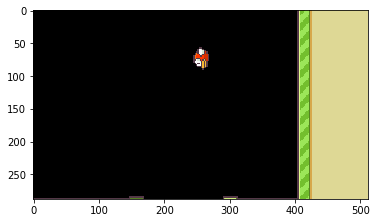

In [9]:
plt.imshow(x_t)

In [10]:
x_t1_colored, r_t, terminal = game_state.frame_step(do_nothing)

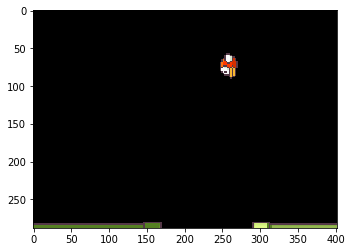

In [11]:
plt.imshow(x_t1_colored[:,:-110,:])

In [12]:
x_t1_colored[:,:-110,:].shape

(288, 402, 3)

In [13]:
x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored[:,:-110,:], (80, 80)), cv2.COLOR_BGR2GRAY)

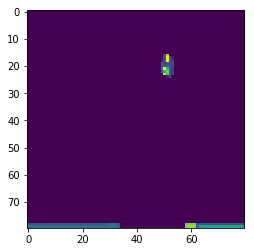

In [14]:
plt.imshow(x_t1)

In [16]:
x_t1

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [ 64,  64,  64, ...,  64,  64,  64],
       [ 95,  95,  95, ..., 144, 145, 144]], dtype=uint8)

In [18]:
ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)

In [24]:
x_t1[20:25,:]/255

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.